In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import warnings

warnings.filterwarnings('ignore')

# Описание проекта

Для планирования продаж и рекламных кампаний  интернет-магазина "Стримчик" необходимо провести анализ исторических данных о продажах игр.
**Цель проекта:**  выявить определяющие успешность игры закономерности

Для выполнения цели следует выполнить следующие шаги:
1. Ознакомиться с данными, определить периоды анализа для планирования
2. Выполнить предобработку данных на дубли и пустые значения
3. Провести исследовательский анализ данных:
     - проанализировать динамику выхода игр
     - проанализировать динамику продаж на разных платформах, выявить наиболее предпочтительные платформы
     - определить период, данные за который будут полезны для дальшейшего анализа и прогнозирования
     - определить степень влияния отзывов пользователей и критиков на продажи внутри платформы
     - выявить самые продаваемые жанры игр
4. Составить портрет пользователя каждого из основных регионов
5. Проверить гипотезы о пользовательских рейтингах
6. Сделать итоговые выводы

## Подготовка данных

In [ ]:
try:
    data = pd.read_csv('/datasets/games.csv')
except:
    print('Не удалось прочитать файл с данными')

In [ ]:
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


Для анализа предоставлены следующие данные:
- `Name` — название игры
- `Platform` — платформа
- `Year_of_Release` — год выпуска
- `Genre` — жанр игры
- `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
- `EU_sales` — продажи в Европе (миллионы проданных копий)
- `JP_sales` — продажи в Японии (миллионы проданных копий)
- `Other_sales` — продажи в других странах (миллионы проданных копий)
- `Critic_Score` — оценка критиков (максимум 100)
- `User_Score` — оценка пользователей (максимум 10)
- `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [ ]:
data['Platform'].nunique()

31

Представлены данные об играх, выходивших на 31 платформе

In [ ]:
display(data['Genre'].unique())
data['Genre'].nunique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy', nan], dtype=object)

12

Игры разделены на 11 жанров (nan не в счет). Отдельно следует рассматривать жанр `Misc` (Miscellaneous game), т.к. по сути это игры не попавшие в другие разделы

In [ ]:
display(data['Rating'].unique())
data['Rating'].nunique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

8

Рейтинг ESRB  разрешает или запрещает(не рекомендует) игру детям или подросткам с определенного возраста.
Наименьший возрастной ценз  «EC» («Early childhood») — «Для детей младшего возраста»: Игра подходит для детей от 3 лет
Самый "суровый" - «AO» («Adults Only 18+») — «Только для взрослых»

Особо следует обратить внимание:
1. «RP» («Rating Pending») — «Рейтинг ожидается» - означает что игра все отправлена на рассмотрение ESRB, но рейтинг еще не присвоен
2. Рейтинг К-А (Kids to Adults) устарел, ранее использовался вместо рейтинга «E» («Everyone») — «Для всех». В целях анализа, эти рейтинги стоит уравнять
3. ESRB была основана в 1994 году, поэтому стоит ожидать, что игры чей пик продаж пришелся раньше этого года не подавались на оценку организации, соответственно с большой вероятностью не будут иметь присвоенного рейтинга

In [ ]:
display(sorted(data['Year_of_Release'].unique()))
data['Year_of_Release'].nunique()

[1980.0,
 1981.0,
 1982.0,
 1983.0,
 1984.0,
 1985.0,
 1986.0,
 1987.0,
 1988.0,
 1989.0,
 1990.0,
 1991.0,
 1992.0,
 1993.0,
 1994.0,
 1995.0,
 1996.0,
 1997.0,
 1998.0,
 1999.0,
 2000.0,
 2001.0,
 2002.0,
 2003.0,
 2004.0,
 2005.0,
 2006.0,
 2007.0,
 2008.0,
 2009.0,
 2010.0,
 2011.0,
 2012.0,
 2013.0,
 2014.0,
 2015.0,
 2016.0,
 nan]

37

Представлены данные с 1980 по 2016 годы. "Пробелов" (годов без выпущенных игр) нет.  

In [ ]:
data['Critic_Score'].describe()

count    8137.000000
mean       68.967679
std        13.938165
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: Critic_Score, dtype: float64

Максимально возможное значение оценки критиков - 100 баллов, однако ни одна игра не получила такую оценку (максимальная 98). Минимальная вероятно 1, однако в данных минимальная оценка 13.

In [ ]:
data['User_Score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Оценка пользователей более категорична, здесь есть 0 в качестве минимальной оценки, максимальная оценка 9.7, так же отдельно есть значение `tbd`, которое означает, что оценка еще не рассчитана, видимо игра вышла сравнительно недавно и оценок пользователей недостаточно, чтобы сформировать окончательную оценку

<AxesSubplot:>

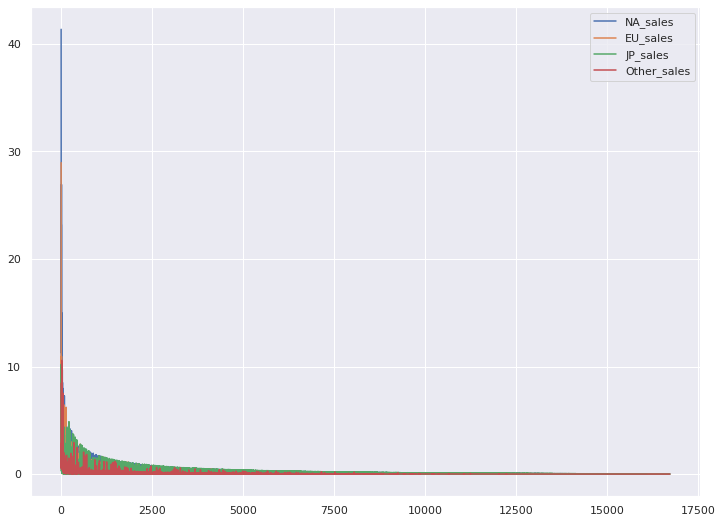

In [ ]:
data[['NA_sales', 'EU_sales', 'JP_sales', 'Other_sales']].plot(figsize =(12,9))


**Вывод:** К анализу предоставлены данные о продажах игр за период с 1980 по 2016 год. Игры разделены
- на 11 жанров
- 31 платформы (деление очень условное, т.к. некоторые игры выходили на нескольких платформах)
- Рейтинг целевой аудитории по возрасту Entertainment Software Rating Board (ESRB)

Качество игр оценено по двум критерям:
- оценка пользователей
- оценка критиков

Данные  о продажах разбиты на регионы:
- Северная Америка
- Европа
- Япония
- остальные страны

## Предобработка данных

Для удобства дальнейшего анализа унифицируем наименования столбцов

In [ ]:
names_columns = []
for i in data.columns:
    names_columns.append(i.lower())
data.columns = names_columns
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Проверим данные на пропуски

In [ ]:
def chec_nulls(data):
    count_of_data = data.count()
    display(data.isna().sum().sort_values())
    display(round(data.isna().sum()/count_of_data*100, 2).sort_values())
chec_nulls(data)

platform              0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
name                  2
genre                 2
year_of_release     269
user_score         6701
rating             6766
critic_score       8578
dtype: int64

platform             0.00
na_sales             0.00
eu_sales             0.00
jp_sales             0.00
other_sales          0.00
name                 0.01
genre                0.01
year_of_release      1.64
user_score          66.92
rating              68.01
critic_score       105.42
dtype: float64

Пропусков нет в данных о платформе и о продажах по регионам.

Есть две безымянных игры. Это составляет 0,01% от всех данных. Посмотрим на данные, возможно и имеет ли смысл их восстанавливать

In [ ]:
excluded_data_name = data[data['name'].isna()]
excluded_data_name

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Две игры 1993 года на платформе  Sega Mega Drive (Genesis), одна из них вероятно продавалась только в Японии, другая наоборот везде кроме Японии. Возможно можно найти эти игры, но с учетом доли в объеме данных и отсутствием жанра игры вероятность ошибочно идентифицировать игру больше, чем вероятность что восстановленные  данные принесут пользу для анализа.
Причиной таких пропусков могло быть некорректное соединение данных при сборе или несоответствие языка, на котором были внесены данные о названии и жанре языку базы данных.

In [ ]:
data = data[~data['name'].isna()]
chec_nulls(data)

name                  0
platform              0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
year_of_release     269
user_score         6699
rating             6764
critic_score       8576
dtype: int64

name                 0.00
platform             0.00
genre                0.00
na_sales             0.00
eu_sales             0.00
jp_sales             0.00
other_sales          0.00
year_of_release      1.64
user_score          66.90
rating              67.99
critic_score       105.40
dtype: float64

Вместе с пропусками в столце `name` удалены так же и пропуске в столбце `genre`

Теперь рассмотрим пропуске в графе год выхода, они составляют уже 1,64% данных

In [ ]:
shape_data_year = data[data['year_of_release'].isna()]
shape_data_year

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Среди данных есть названия игр, которые содержат в себе год выпуска как например FIFA Soccer 2004 и Madden NFL 2004. Проверим, сможем ли мы таким образом заполнить пропуски

In [ ]:
i = 1980 #предоставлены данные с 1980 по 2016й годы
while i <= 2016:
    if data[data['name'].str.contains(str(i))]['name'].count() > 0:
        display(data[data['name'].str.contains(str(i))])
    i +=1

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
10579,Olympic Summer Games: Atlanta 1996,PS,1996.0,Sports,0.06,0.04,0.0,0.01,NaN,NaN,NaN
12881,Olympic Soccer: Atlanta 1996,PS,1996.0,Sports,0.03,0.02,0.0,0.00,NaN,NaN,NaN


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
3687,Gekikuukan Pro Yakyuu: At the End of the Centu...,PS2,2000.0,Sports,0.0,0.0,0.54,0.0,NaN,NaN,NaN
10522,The King of Fighters: Dream Match 1999,DC,1999.0,Fighting,0.0,0.0,0.10,0.0,NaN,NaN,NaN


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
769,SimCity 2000,PC,1992.0,Simulation,1.20,0.84,0.00,0.10,NaN,NaN,NaN
926,FIFA 2000,PS,1998.0,Sports,0.22,1.47,0.04,0.14,NaN,NaN,NaN
973,NFL GameDay 2000,PS,1999.0,Sports,1.00,0.68,0.00,0.12,NaN,NaN,NaN
1004,Madden NFL 2000,PS,1998.0,Sports,1.68,0.04,0.00,0.04,NaN,NaN,NaN
1166,NASCAR 2000,PS,1999.0,Racing,0.88,0.60,0.00,0.10,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
13800,Rally Challenge 2000,N64,1999.0,Racing,0.03,0.01,0.00,0.00,NaN,NaN,NaN
13907,NHL Blades of Steel 2000,PS,1999.0,Sports,0.02,0.01,0.00,0.00,NaN,NaN,NaN
14561,Big Mountain 2000,N64,1998.0,Sports,0.02,0.01,0.00,0.00,NaN,NaN,NaN
15892,Simple 2000 Series Vol. 105: The Maid Fuku to ...,PS2,2006.0,Action,0.00,0.00,0.02,0.00,NaN,NaN,NaN


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
944,Gran Turismo Concept 2001 Tokyo,PS2,2001.0,Racing,0.00,1.10,0.42,0.33,NaN,NaN,NaN
1085,Madden NFL 2001,PS,2000.0,Sports,1.58,0.05,0.00,0.04,90.0,6.8,E
1259,Madden NFL 2001,PS2,2000.0,Sports,1.19,0.07,0.05,0.20,91.0,7.7,E
1473,Triple Play 2001,PS,2000.0,Sports,0.74,0.50,0.00,0.09,NaN,NaN,NaN
1582,NBA Live 2001,PS,2000.0,Sports,0.70,0.47,0.00,0.08,86.0,8,E
1862,NBA Live 2001,PS2,2001.0,Sports,0.52,0.40,0.04,0.13,74.0,tbd,E
2071,NFL GameDay 2001,PS,2000.0,Sports,0.56,0.38,0.00,0.07,73.0,tbd,E
2144,NHL 2001,PS2,2000.0,Sports,0.47,0.37,0.00,0.12,85.0,8.1,E
2344,MLB 2001,PS,2000.0,Sports,0.49,0.34,0.00,0.06,NaN,NaN,NaN
2530,NASCAR 2001,PS,2000.0,Racing,0.45,0.31,0.00,0.05,73.0,6.1,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
452,Madden NFL 2002,PS2,2001.0,Sports,2.50,0.16,0.01,0.42,94.0,7.9,E
937,NBA Live 2002,PS2,2001.0,Sports,0.91,0.71,0.00,0.24,70.0,7.4,E
1178,NCAA Football 2002,PS2,2001.0,Sports,0.77,0.60,0.00,0.20,90.0,8.7,E
1387,Madden NFL 2002,PS,2001.0,Sports,0.78,0.53,0.00,0.09,88.0,8,E
1686,NHL 2002,PS2,2001.0,Sports,0.59,0.46,0.00,0.15,92.0,8.5,E
...,...,...,...,...,...,...,...,...,...,...,...
15501,ESPN MLS ExtraTime 2002,GC,2002.0,Sports,0.02,0.00,0.00,0.00,68.0,tbd,E
15583,ESPN MLS ExtraTime 2002,XB,2002.0,Sports,0.01,0.00,0.00,0.00,68.0,tbd,E
15693,ESPN NFL Primetime 2002,XB,2002.0,Sports,0.01,0.00,0.00,0.00,57.0,tbd,E
16257,King of Fighters 2002: Unlimited Match Tougeki...,PS2,2010.0,Fighting,0.00,0.00,0.01,0.00,NaN,NaN,NaN


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
283,Madden NFL 2003,PS2,2002.0,Sports,3.36,0.21,0.01,0.56,95.0,7.7,E
393,FIFA Soccer 2003,PS2,2002.0,Sports,0.46,2.28,0.05,0.61,88.0,6.7,E
1104,NBA Live 2003,PS2,2002.0,Sports,1.25,0.15,0.03,0.22,83.0,8.3,E
1122,Tiger Woods PGA Tour 2003,PS2,2002.0,Sports,0.80,0.63,0.00,0.21,88.0,8.9,E
1333,NCAA Football 2003,PS2,2002.0,Sports,1.16,0.08,0.00,0.19,91.0,8.6,E
1650,NASCAR Thunder 2003,PS2,NaN,Racing,0.60,0.46,0.00,0.16,84.0,8.7,E
1982,MVP Baseball 2003,PS2,2003.0,Sports,0.51,0.40,0.00,0.13,81.0,8.9,E
2208,NHL 2003,PS2,2002.0,Sports,0.46,0.36,0.00,0.12,79.0,6.8,E
2666,All-Star Baseball 2003,PS2,2002.0,Sports,0.38,0.29,0.00,0.10,81.0,8.4,E
2862,Madden NFL 2003,XB,2002.0,Sports,0.67,0.02,0.00,0.03,92.0,8.3,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
841,NBA Live 2004,PS2,2003.0,Sports,1.57,0.18,0.00,0.27,86.0,7.7,E
1093,NCAA Football 2004,PS2,2003.0,Sports,1.35,0.09,0.00,0.23,94.0,8.8,E
1129,Tiger Woods PGA Tour 2004,PS2,2003.0,Sports,1.18,0.34,0.00,0.10,89.0,8.8,E
...,...,...,...,...,...,...,...,...,...,...,...
12935,UEFA Euro 2004: Portugal,XB,2004.0,Sports,0.04,0.01,0.00,0.00,74.0,8.1,E
13086,FIFA Soccer 2004,GBA,2003.0,Sports,0.04,0.01,0.00,0.00,82.0,7.9,E
13338,World Championship Pool 2004,PS2,2004.0,Sports,0.02,0.02,0.00,0.01,60.0,6.7,E
14069,World Championship Pool 2004,XB,2003.0,Sports,0.03,0.01,0.00,0.00,67.0,tbd,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
238,Madden NFL 2005,PS2,2004.0,Sports,4.18,0.26,0.01,0.08,91.0,7.9,E
338,FIFA Soccer 2005,PS2,2004.0,Sports,0.58,2.48,0.04,0.59,81.0,7.6,E
590,NBA Live 2005,PS2,2004.0,Sports,2.03,0.21,0.00,0.35,84.0,8.1,E
1038,Madden NFL 2005,XB,2004.0,Sports,1.61,0.03,0.00,0.08,91.0,7.6,E
1133,NCAA Football 2005,PS2,2004.0,Sports,1.32,0.09,0.00,0.22,88.0,8.8,E
1217,MVP Baseball 2005,PS2,2005.0,Sports,1.26,0.07,0.00,0.21,87.0,8.6,E
1332,Tiger Woods PGA Tour 2005,PS2,2004.0,Sports,1.03,0.32,0.00,0.09,88.0,8.2,E
1373,NASCAR 2005: Chase for the Cup,PS2,2004.0,Racing,0.69,0.54,0.00,0.18,87.0,8.4,E
2125,FIFA Soccer 2005,XB,2004.0,Sports,0.33,0.60,0.00,0.04,81.0,8.7,E
2195,MVP Baseball 2005,XB,2005.0,Sports,0.70,0.20,0.00,0.03,86.0,NaN,NaN


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
488,WWE SmackDown! vs. RAW 2006,PS2,2005.0,Fighting,1.45,1.11,0.04,0.33,NaN,NaN,NaN
3524,FIFA World Cup Germany 2006,PS2,2006.0,Sports,0.47,0.02,0.00,0.08,77.0,8.1,E
4121,FIFA World Cup Germany 2006,X360,2006.0,Sports,0.19,0.27,0.01,0.00,72.0,6.6,E
4812,MLB 2006,PS2,2005.0,Sports,0.33,0.01,0.00,0.05,81.0,9,E
4832,WWE SmackDown! vs. RAW 2006,PSP,2005.0,Fighting,0.36,0.00,0.00,0.03,81.0,8.5,T
5250,Backyard Baseball 2006,GBA,2005.0,Sports,0.25,0.09,0.00,0.01,NaN,NaN,NaN
5251,Cabela's Outdoor Adventures (2006),PS2,2005.0,Sports,0.17,0.14,0.00,0.05,NaN,8.9,T
6449,MLB SlugFest 2006,PS2,2006.0,Sports,0.13,0.10,0.00,0.03,56.0,7.5,E10+
6486,Yu-Gi-Oh! Ultimate Masters: World Championship...,GBA,2006.0,Misc,0.14,0.05,0.07,0.01,NaN,NaN,NaN


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
250,Winning Eleven: Pro Evolution Soccer 2007,PS2,2006.0,Sports,0.10,2.39,1.05,0.86,86.0,8.9,E
594,WWE SmackDown vs. RAW 2007,PS2,2006.0,Fighting,1.40,0.88,0.03,0.26,80.0,8.6,T
2069,Winning Eleven: Pro Evolution Soccer 2007 (All...,X360,2006.0,Sports,0.08,0.90,0.02,0.00,NaN,NaN,NaN
2418,Winning Eleven: Pro Evolution Soccer 2007,PSP,2006.0,Sports,0.01,0.72,0.12,0.01,81.0,8.3,E
3033,WWE SmackDown vs. RAW 2007,PSP,2006.0,Fighting,0.33,0.20,0.00,0.14,78.0,8.1,T
3944,WWE SmackDown vs. RAW 2007,X360,2006.0,Fighting,0.44,0.03,0.00,0.04,81.0,7.8,T
4116,Scrabble 2007 Edition,DS,2007.0,Puzzle,0.00,0.47,0.00,0.00,NaN,NaN,NaN
5767,J-League Winning Eleven 2007: Club Championship,PS2,2007.0,Sports,0.00,0.00,0.31,0.00,NaN,NaN,NaN
8216,Winning Eleven: Pro Evolution Soccer 2007,DS,2006.0,Sports,0.00,0.00,0.17,0.00,63.0,7.9,E
8576,World Series of Poker: Tournament of Champions...,X360,2006.0,Misc,0.15,0.00,0.00,0.01,NaN,NaN,NaN


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
349,Pro Evolution Soccer 2008,PS2,2007.0,Sports,0.05,0.00,0.64,2.93,82.0,7.9,E
676,WWE SmackDown vs Raw 2008,PS2,2007.0,Fighting,0.92,0.00,0.01,1.41,71.0,7.2,T
1165,Pro Evolution Soccer 2008,PS3,2007.0,Sports,0.04,1.10,0.32,0.13,74.0,6.1,E
1336,WWE SmackDown vs Raw 2008,X360,2007.0,Fighting,0.92,0.38,0.00,0.13,71.0,6.8,T
1477,WWE SmackDown vs Raw 2008,PS3,2007.0,Fighting,0.62,0.49,0.01,0.20,74.0,7.3,T
1693,Pro Evolution Soccer 2008,Wii,2008.0,Sports,0.09,0.84,0.11,0.15,83.0,8.4,E
1701,WWE SmackDown vs Raw 2008,PSP,2007.0,Fighting,0.45,0.47,0.00,0.28,68.0,7.8,T
1829,Worldwide Soccer Manager 2008,PC,2007.0,Sports,0.00,1.12,0.00,0.00,86.0,8,E
1926,Pro Evolution Soccer 2008,X360,2007.0,Sports,0.08,0.90,0.04,0.05,76.0,7.8,E
2095,Pro Evolution Soccer 2008,PSP,2008.0,Sports,0.02,0.53,0.19,0.25,80.0,6.8,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
617,PES 2009: Pro Evolution Soccer,PS2,2008.0,Sports,0.13,0.07,0.26,2.05,NaN,NaN,NaN
783,PES 2009: Pro Evolution Soccer,PS3,2008.0,Sports,0.11,1.33,0.40,0.26,NaN,NaN,NaN
816,UFC 2009 Undisputed,X360,2009.0,Fighting,1.48,0.39,0.00,0.19,83.0,7.9,T
993,UFC 2009 Undisputed,PS3,2009.0,Fighting,1.07,0.44,0.01,0.24,84.0,8.1,T
1562,Jillian Michaels' Fitness Ultimatum 2009,Wii,2008.0,Sports,0.96,0.20,0.00,0.11,30.0,2,E
1607,WWE SmackDown vs. Raw 2009,PS2,2008.0,Fighting,0.69,0.00,0.00,0.55,78.0,6.9,T
1758,Worldwide Soccer Manager 2009,PC,2008.0,Simulation,0.00,1.14,0.00,0.01,83.0,8.1,E
2068,PES 2009: Pro Evolution Soccer,X360,2008.0,Sports,0.13,0.76,0.03,0.09,NaN,NaN,NaN
2198,WWE SmackDown vs. Raw 2009,PS3,2008.0,Fighting,0.51,0.30,0.01,0.12,78.0,7,T
2258,WWE SmackDown vs. Raw 2009,X360,2008.0,Fighting,0.58,0.26,0.00,0.08,79.0,7.1,T


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
697,Pro Evolution Soccer 2010,PS3,2009.0,Sports,0.30,1.27,0.46,0.26,78.0,6.7,E
954,GoldenEye 007 (2010),Wii,2010.0,Action,0.84,0.70,0.13,0.16,NaN,NaN,NaN
1058,Cabela's Big Game Hunter 2010,Wii,2009.0,Sports,1.58,0.00,0.00,0.12,NaN,7.8,T
1177,Pro Evolution Soccer 2010,PS2,2009.0,Sports,0.10,0.18,0.12,1.16,NaN,8.1,E
1362,UFC Undisputed 2010,PS3,2010.0,Fighting,0.80,0.40,0.02,0.18,85.0,7.2,T
...,...,...,...,...,...,...,...,...,...,...,...
13074,Winning Post 7 2010,PSP,2010.0,Sports,0.00,0.00,0.05,0.00,NaN,NaN,NaN
13260,J-League Winning Eleven 2010: Club Championship,PS2,2010.0,Sports,0.00,0.00,0.05,0.00,NaN,NaN,NaN
13764,Winning Post World 2010,PS3,2010.0,Sports,0.00,0.00,0.04,0.00,NaN,NaN,NaN
16401,Championship Manager 2010,PC,2009.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
649,pro evolution soccer 2011,PS3,2010.0,Sports,0.29,1.17,0.54,0.41,77.0,6.8,E
1574,Football Manager 2011,PC,2010.0,Sports,0.00,1.01,0.00,0.25,85.0,8.4,E
1676,F1 2011,PS3,2011.0,Racing,0.12,0.74,0.11,0.24,82.0,7.1,E
1887,WWE SmackDown vs. Raw 2011,PS3,2010.0,Fighting,0.44,0.46,0.01,0.18,74.0,6.9,T
2373,WWE SmackDown vs. Raw 2011,X360,2010.0,Fighting,0.44,0.35,0.00,0.08,75.0,7.6,T
2583,pro evolution soccer 2011,PSP,2010.0,Sports,0.05,0.30,0.29,0.16,74.0,5.8,E
2852,F1 2011,X360,2011.0,Racing,0.11,0.50,0.01,0.09,84.0,7.1,E
2922,WWE SmackDown vs. Raw 2011,PSP,2010.0,Fighting,0.22,0.31,0.00,0.17,NaN,6.7,T
3304,pro evolution soccer 2011,X360,2010.0,Sports,0.09,0.44,0.00,0.07,79.0,5.9,E
3504,Cabela's Dangerous Hunts 2011,Wii,2010.0,Sports,0.52,0.02,0.00,0.04,NaN,tbd,T


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
333,Mario & Sonic at the London 2012 Olympic Games,Wii,2011.0,Sports,1.12,1.87,0.27,0.45,NaN,NaN,NaN
750,Pro Evolution Soccer 2012,PS3,2011.0,Action,0.34,0.96,0.55,0.33,80.0,6.6,E
1252,Football Manager 2012,PC,2011.0,Sports,0.02,1.16,0.00,0.33,84.0,8,E
1708,Mario & Sonic at the London 2012 Olympic Games,3DS,2012.0,Sports,0.18,0.64,0.27,0.09,NaN,NaN,NaN
1752,Your Shape: Fitness Evolved 2012,X360,2011.0,Sports,0.70,0.36,0.00,0.10,77.0,7.6,E
2000,F1 2012,PS3,2012.0,Racing,0.12,0.63,0.05,0.23,81.0,7.5,E
2531,Twisted Metal (2012),PS3,2012.0,Action,0.67,0.07,0.00,0.08,NaN,NaN,NaN
3010,London 2012: The Official Video Game of the Ol...,PS3,2012.0,Sports,0.06,0.48,0.00,0.14,NaN,NaN,NaN
3485,London 2012: The Official Video Game of the Ol...,X360,2012.0,Sports,0.07,0.44,0.00,0.07,NaN,NaN,NaN
3534,Pro Evolution Soccer 2012,PSP,2011.0,Action,0.10,0.11,0.29,0.06,74.0,6.3,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
646,Tomb Raider (2013),PS3,2013.0,Action,0.60,1.26,0.08,0.48,NaN,NaN,NaN
910,Tomb Raider (2013),X360,2013.0,Action,0.86,0.84,0.01,0.17,NaN,NaN,NaN
1221,Pro Evolution Soccer 2013,PS3,2012.0,Sports,0.18,0.63,0.49,0.24,82.0,6.7,E
1351,SimCity (2013),PC,2013.0,Simulation,0.48,0.77,0.00,0.17,64.0,2.2,E10+
1384,Tomb Raider (2013),PS4,2014.0,Action,0.47,0.65,0.06,0.22,NaN,NaN,NaN
1763,Football Manager 2013,PC,2012.0,Sports,0.00,0.95,0.00,0.21,86.0,6.7,NaN
2145,Farming Simulator 2013,PC,2012.0,Simulation,0.00,0.81,0.00,0.15,65.0,7.5,E
3309,Tomb Raider (2013),XOne,2014.0,Action,0.35,0.21,0.00,0.05,NaN,NaN,NaN
3685,F1 2013,PS3,2013.0,Racing,0.01,0.42,0.03,0.09,77.0,6.3,E
4967,Farming Simulator 2013,X360,2013.0,Simulation,0.22,0.13,0.00,0.04,33.0,6.2,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
359,Just Dance 2014,Wii,2013.0,Misc,1.88,1.39,0.00,0.31,NaN,6.2,E10+
2077,Just Dance 2014,X360,2013.0,Misc,0.72,0.17,0.00,0.10,79.0,7.8,E10+
2109,Rocksmith 2014,PS3,2013.0,Misc,0.53,0.24,0.05,0.16,NaN,NaN,NaN
2168,Pro Evolution Soccer 2014,PS3,2013.0,Action,0.03,0.41,0.51,0.00,78.0,4.1,E
2191,Rocksmith 2014,X360,2013.0,Misc,0.69,0.16,0.00,0.09,NaN,NaN,NaN
2521,Thief (2014),PS4,2014.0,Action,0.28,0.38,0.03,0.13,NaN,NaN,NaN
2636,Mario & Sonic at the Sochi 2014 Olympic Winter...,WiiU,2013.0,Sports,0.37,0.22,0.13,0.06,NaN,NaN,NaN
3087,Rocksmith 2014,PC,2013.0,Misc,0.36,0.24,0.00,0.06,NaN,NaN,NaN
3150,Football Manager 2014,PC,2013.0,Sports,0.00,0.60,0.00,0.03,85.0,5.5,E
3200,Rocksmith 2014,PS4,2014.0,Misc,0.35,0.17,0.00,0.11,NaN,NaN,NaN


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
87,Star Wars Battlefront (2015),PS4,2015.0,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN
342,Star Wars Battlefront (2015),XOne,2015.0,Shooter,2.04,1.28,0.02,0.32,NaN,NaN,NaN
639,Need for Speed (2015),PS4,2015.0,Racing,0.50,1.50,0.05,0.37,NaN,NaN,NaN
850,Just Dance 2015,Wii,2014.0,Misc,0.99,0.85,0.00,0.17,NaN,8.4,E10+
1677,Farming Simulator 2015,PC,2014.0,Simulation,0.08,1.04,0.00,0.07,NaN,NaN,NaN
1726,Mad Max (2015),PS4,2015.0,Action,0.36,0.59,0.04,0.18,NaN,NaN,NaN
2734,Pro Evolution Soccer 2015,PS4,2014.0,Sports,0.09,0.45,0.11,0.10,82.0,7.2,E
2813,Just Dance 2015,WiiU,2014.0,Misc,0.38,0.29,0.00,0.06,75.0,6.6,E10+
2954,Need for Speed (2015),XOne,2015.0,Racing,0.30,0.33,0.00,0.06,NaN,NaN,NaN
3035,F1 2015,PS4,2015.0,Racing,0.09,0.45,0.03,0.10,65.0,6.3,E


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1216,Ratchet & Clank (2016),PS4,2016.0,Platform,0.50,0.76,0.04,0.24,NaN,NaN,NaN
1275,Doom (2016),PS4,2016.0,Shooter,0.54,0.69,0.02,0.24,NaN,NaN,NaN
2179,Just Dance 2016,Wii,2015.0,Misc,0.41,0.46,0.00,0.08,NaN,tbd,E10+
2600,Pro Evolution Soccer 2016,PS4,2015.0,Sports,0.13,0.42,0.13,0.10,87.0,7.1,E
2694,Doom (2016),XOne,2016.0,Shooter,0.44,0.25,0.00,0.07,NaN,NaN,NaN
3537,Just Dance 2016,WiiU,2015.0,Misc,0.27,0.25,0.00,0.05,73.0,6.9,E10+
3788,Mario & Sonic at the Rio 2016 Olympic Games,3DS,2016.0,Action,0.05,0.21,0.25,0.02,NaN,NaN,NaN
4836,Pro Evolution Soccer 2016,PS3,2015.0,Sports,0.09,0.12,0.15,0.04,NaN,7.2,E
4943,F1 2016 (Codemasters),PS4,2016.0,Racing,0.03,0.29,0.01,0.05,NaN,NaN,NaN
5215,Just Dance 2016,PS4,2015.0,Misc,0.17,0.13,0.00,0.06,73.0,6.8,E10+


Не везде год в названии совпадает с годом выхода игры. Проверим насколько мы можем ошибиться

In [ ]:
i = 1980 #предоставлены данные с 1980 по 2016й годы

total_matches = 0
total_game = 0
while i <= 2016:
    if data[data['name'].str.contains(str(i)) & (~data['year_of_release'].isna())]['name'].count() > 0:
        count_in_year =data[data['name'].str.contains(str(i)) & (~data['year_of_release'].isna())]['name'].count()
        year_matches =data[(data['name'].str.contains(str(i))) & (data['year_of_release']==i)]['name'].count()
        print("В году", i, 'совпало', year_matches, "из", count_in_year, round(year_matches/count_in_year*100, 2), "%" )
        total_matches += year_matches
        total_game += count_in_year
    i +=1
print('Общая доля совпадений', round(total_matches/total_game*100, 2), "%" )

В году 1996 совпало 2 из 2 100.0 %
В году 1999 совпало 1 из 2 50.0 %
В году 2000 совпало 18 из 67 26.87 %
В году 2001 совпало 20 из 49 40.82 %
В году 2002 совпало 37 из 78 47.44 %
В году 2003 совпало 9 из 47 19.15 %
В году 2004 совпало 13 из 59 22.03 %
В году 2005 совпало 6 из 50 12.0 %
В году 2006 совпало 20 из 33 60.61 %
В году 2007 совпало 11 из 26 42.31 %
В году 2008 совпало 19 из 44 43.18 %
В году 2009 совпало 26 из 49 53.06 %
В году 2010 совпало 40 из 67 59.7 %
В году 2011 совпало 29 из 49 59.18 %
В году 2012 совпало 16 из 37 43.24 %
В году 2013 совпало 19 из 31 61.29 %
В году 2014 совпало 30 из 49 61.22 %
В году 2015 совпало 25 из 40 62.5 %
В году 2016 совпало 24 из 39 61.54 %
Общая доля совпадений 44.62 %


Кажется игры с годом в названии стали модными в конце девяностых) Ранее так игры не называли. Однако вероятность попасть в верный год выпуска исходя из названия игры кажется слишком маленькой. *2005й год либо год врунов, либо невыполненных обещаний*

Придется расстаться с этими данными

In [ ]:
excluded_data_years = data[data['year_of_release'].isna()] #сохраним для потомков
data = data[~data['year_of_release'].isna()]

chec_nulls(data)

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
user_score         6605
rating             6676
critic_score       8461
dtype: int64

name                 0.00
platform             0.00
year_of_release      0.00
genre                0.00
na_sales             0.00
eu_sales             0.00
jp_sales             0.00
other_sales          0.00
user_score          67.13
rating              68.35
critic_score       105.99
dtype: float64

После удаления из данных о годе выпуска пропусков сможем преобразовать значения в более подходящий тип

In [ ]:
data['year_of_release'] = data['year_of_release'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   object 
 10  rating           9768 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 1.5+ MB


При знакомстве с данными мы обратили внимание, что в данных об оценках пользователей есть значение 'tbd', означающее что значение будет заполнено позже. Наличие этой пометки помешает нам привести данные к численному типу и проанализировать в будущем. Проверим в какие годы и сколько таких значений попадает:

In [ ]:
tbd_year_count = data[data['user_score']== 'tbd'].groupby('year_of_release')['name'].agg('count')
year_count = data.groupby('year_of_release')['name'].agg('count')
tbd_year_df = pd.concat([tbd_year_count, year_count], axis = 1).reset_index()
tbd_year_df.columns = ['year','null_count', 'total_count']
tbd_year_df = tbd_year_df[tbd_year_df['null_count']>0]
tbd_year_df['share_null'] = round(tbd_year_df['null_count']/tbd_year_df['total_count']*100,2)
tbd_year_df

,year,null_count,total_count,share_null
17,1997,1.0,289,0.35
19,1999,8.0,338,2.37
20,2000,43.0,350,12.29
21,2001,82.0,482,17.01
22,2002,192.0,829,23.16
23,2003,95.0,775,12.26
24,2004,107.0,762,14.04
25,2005,121.0,939,12.89
26,2006,124.0,1006,12.33
27,2007,192.0,1197,16.04


В контексте оценок зрителей значение "tbd" имеет тот же смысл, что и пропущенное значение. Поэтому, чтобы иметь возможность строить графики и работать с колонкой как с численной, можем заменить это значение на пустое

In [ ]:
display(data[data['user_score']== 'tbd']['name'].count())
data = data.replace({'user_score':{'tbd':None}})
data[data['user_score']== 'tbd']['name'].count()

2376

0

Значения изменены на пустые, теперь мы можем изменить тип значения колонки на численный, при знакомстве с данными мы видели что значения оценок зрителей учитываются до 1 знака после запятой, поэтому выберем тип данных с плавающей точкой

In [ ]:
data['user_score'] = data['user_score'].astype('float')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           9768 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


Пропуски в данных об оценках критиков и пользователей могут быть связаны с годами выпуска. Проверим в каких годах наибольшее количество пропусков

In [ ]:
null_year_count = data[data['user_score'].isna()].groupby('year_of_release')['name'].agg('count')
year_count = data.groupby('year_of_release')['name'].agg('count')
null_year_df = pd.concat([null_year_count, year_count], axis = 1).reset_index()
null_year_df.columns = ['year','null_count', 'total_count']
null_year_df['share_null'] = round(null_year_df['null_count']/null_year_df['total_count']*100,2)
null_year_df

,year,null_count,total_count,share_null
0,1980,9,9,100.00
1,1981,46,46,100.00
2,1982,36,36,100.00
3,1983,17,17,100.00
4,1984,14,14,100.00
5,1985,13,14,92.86
6,1986,21,21,100.00
7,1987,16,16,100.00
8,1988,14,15,93.33
9,1989,17,17,100.00


Действительно до 2001 года для игр без оценок пользователей выше 50%, при этом до 1998 года доля пропусков в этой колонке составляет от 90 до 100%. В более новых данных процент пропусков по годам составляет от 20 до 40%,а значит для этого поля эта ситуация является нормой.

In [ ]:
null_year_count = data[data['critic_score'].isna()].groupby('year_of_release')['name'].agg('count')
year_count = data.groupby('year_of_release')['name'].agg('count')
null_year_df = pd.concat([null_year_count, year_count], axis = 1).reset_index()
null_year_df.columns = ['year','null_count', 'total_count']
null_year_df['share_null'] = round(null_year_df['null_count']/null_year_df['total_count']*100,2)
null_year_df

,year,null_count,total_count,share_null
0,1980,9,9,100.00
1,1981,46,46,100.00
2,1982,36,36,100.00
3,1983,17,17,100.00
4,1984,14,14,100.00
5,1985,13,14,92.86
6,1986,21,21,100.00
7,1987,16,16,100.00
8,1988,14,15,93.33
9,1989,17,17,100.00


Ситуация с оценкой критиков аналогична оценкам пользователей, большое количество пропусков является нормой для этих данных. Принимаем решение не заполнять

Для анализа сводных данных рассчитаем суммарные данные о продажах во всех регионах

In [ ]:
data['total_sales'] = data['na_sales']+data['eu_sales'] + data['jp_sales']+ data['other_sales']
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


**Вывод:** при предобработке данных были выявлены пропуски:
- в колонке с названием игры. Строк с такими пропусками было всего две, что составило 0,01%, строки с этими пропусками были удалены. Причиной таких пропусков могло быть некорректное соединение таблиц при сборе или несоответствие языка, на котором были внесены данные о названии и жанре языку базы данных.
- в колонке с годом выпуска игры в количестве 269 строк, что составилл 1,68% данных. Надежного способа заполнить указанные строки с трудоемкостью адекватной целям исследования выявить не удалось, поэтому строки были удалены.
- в колонке с данными об оценках пользвоателей значение 'tbd' было заменено на пустое, т.к. в контексте значений рейтинга, значение 'tbd' означает именно отсутствие значения (с обещанием, что оно будет заполнено позднее).
- в колонках с данными об оценках пользователей и оценках пользователей пропущено большое количество значений, при этом по играм с годом выпуска ранее 2001 года  данные незаполнены в бОльшей доле игр, скорее всего это связано с тем, что игровая индустрия в те годы еще не обзавелась практикой собирать оценки пользователей и критиков. В при этом даже в данных за 2014-2016 годы процент пропусков в этих колонках 40-60%, а это означает, что для этих данных это норма.

Проведены дополнительные изменения для расширения возможностей последующего анализа:

- типы данных для колонок `year_of_release` и `user_score` были изменены на соответствующие числовые типы
- добавлена и рассчитана колонка `total_sales` с данными о суммарных продажах во всех регионах

## Исследовательский анализ данных

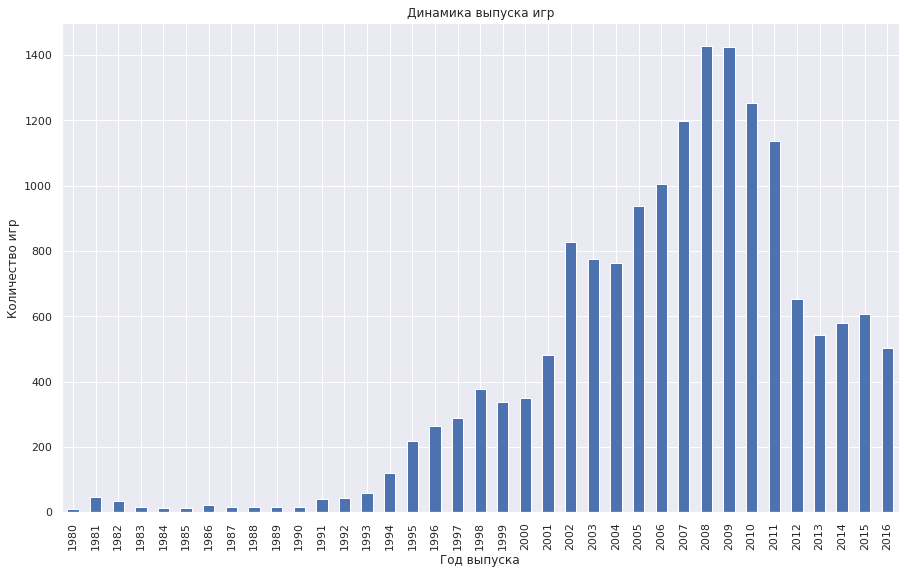

In [ ]:
year_of_release_count = data.groupby('year_of_release')['name'].agg('count')
year_of_release_count.plot.bar(figsize = (15,9), ylabel ='Количество игр',xlabel ='Год выпуска')
plt.title('Динамика выпуска игр')


plt.show()

Начиная с 1991 года количество игр, выпускаемых в год, стало расти. Максимальный пик пришелся на 2008-2009й годы, после которых наблюдается спад количества выпускаемых игр. Но это данные только по количеству, чтобы сделать вывод о полезном для анализа периоде проверим данные о продажах за эти годы

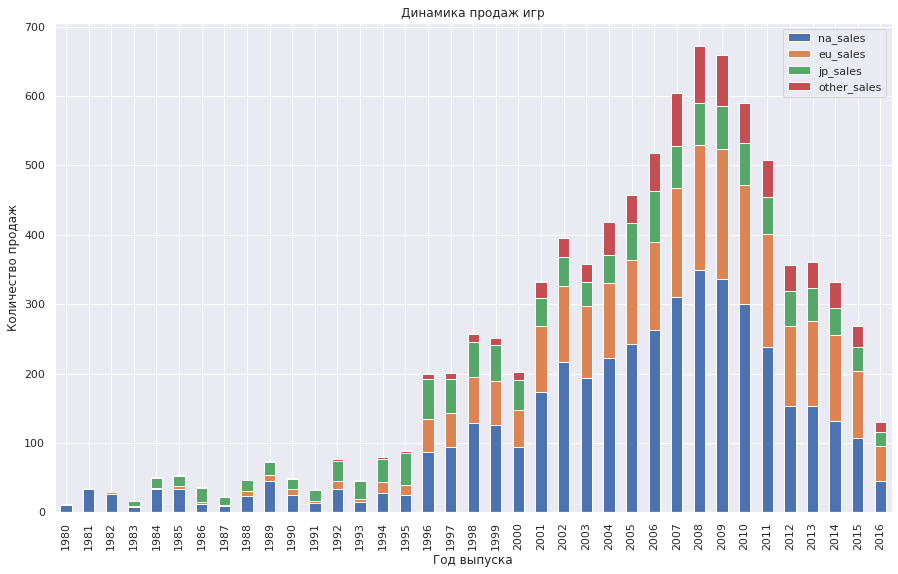

In [ ]:
year_of_release_sales = data.groupby('year_of_release')[['na_sales','eu_sales','jp_sales','other_sales']].agg('sum')
year_of_release_sales.plot.bar( stacked = True,figsize = (15,9), xlabel='Год выпуска', ylabel='Количество продаж')
plt.title('Динамика продаж игр')
plt.show()

Динамика данных по продажах немного отличаются от данные по количеству выпущенных игр, однако общий тренд достаточно схож. По этим данным можем сделать вывод что данные до 1996-го года точно не имеют ценности для анализа с точки зрения прогноза. В дальнейшем будем анализировать данные начиная с 1997, при этом возможно сократим этот период после дополнительных исследований

In [ ]:
data_before_1997 = data[data['year_of_release'] <1997] #сохраняем для потомков
data = data[data['year_of_release'] >=1997]

Проверим данные о продажах в разрезе платформ

In [ ]:
data['platform'].nunique()

22

После удаления устаревших данных для анализа осталось 22 "выжившие" платформы, проверим как изменялись данные по их продажам

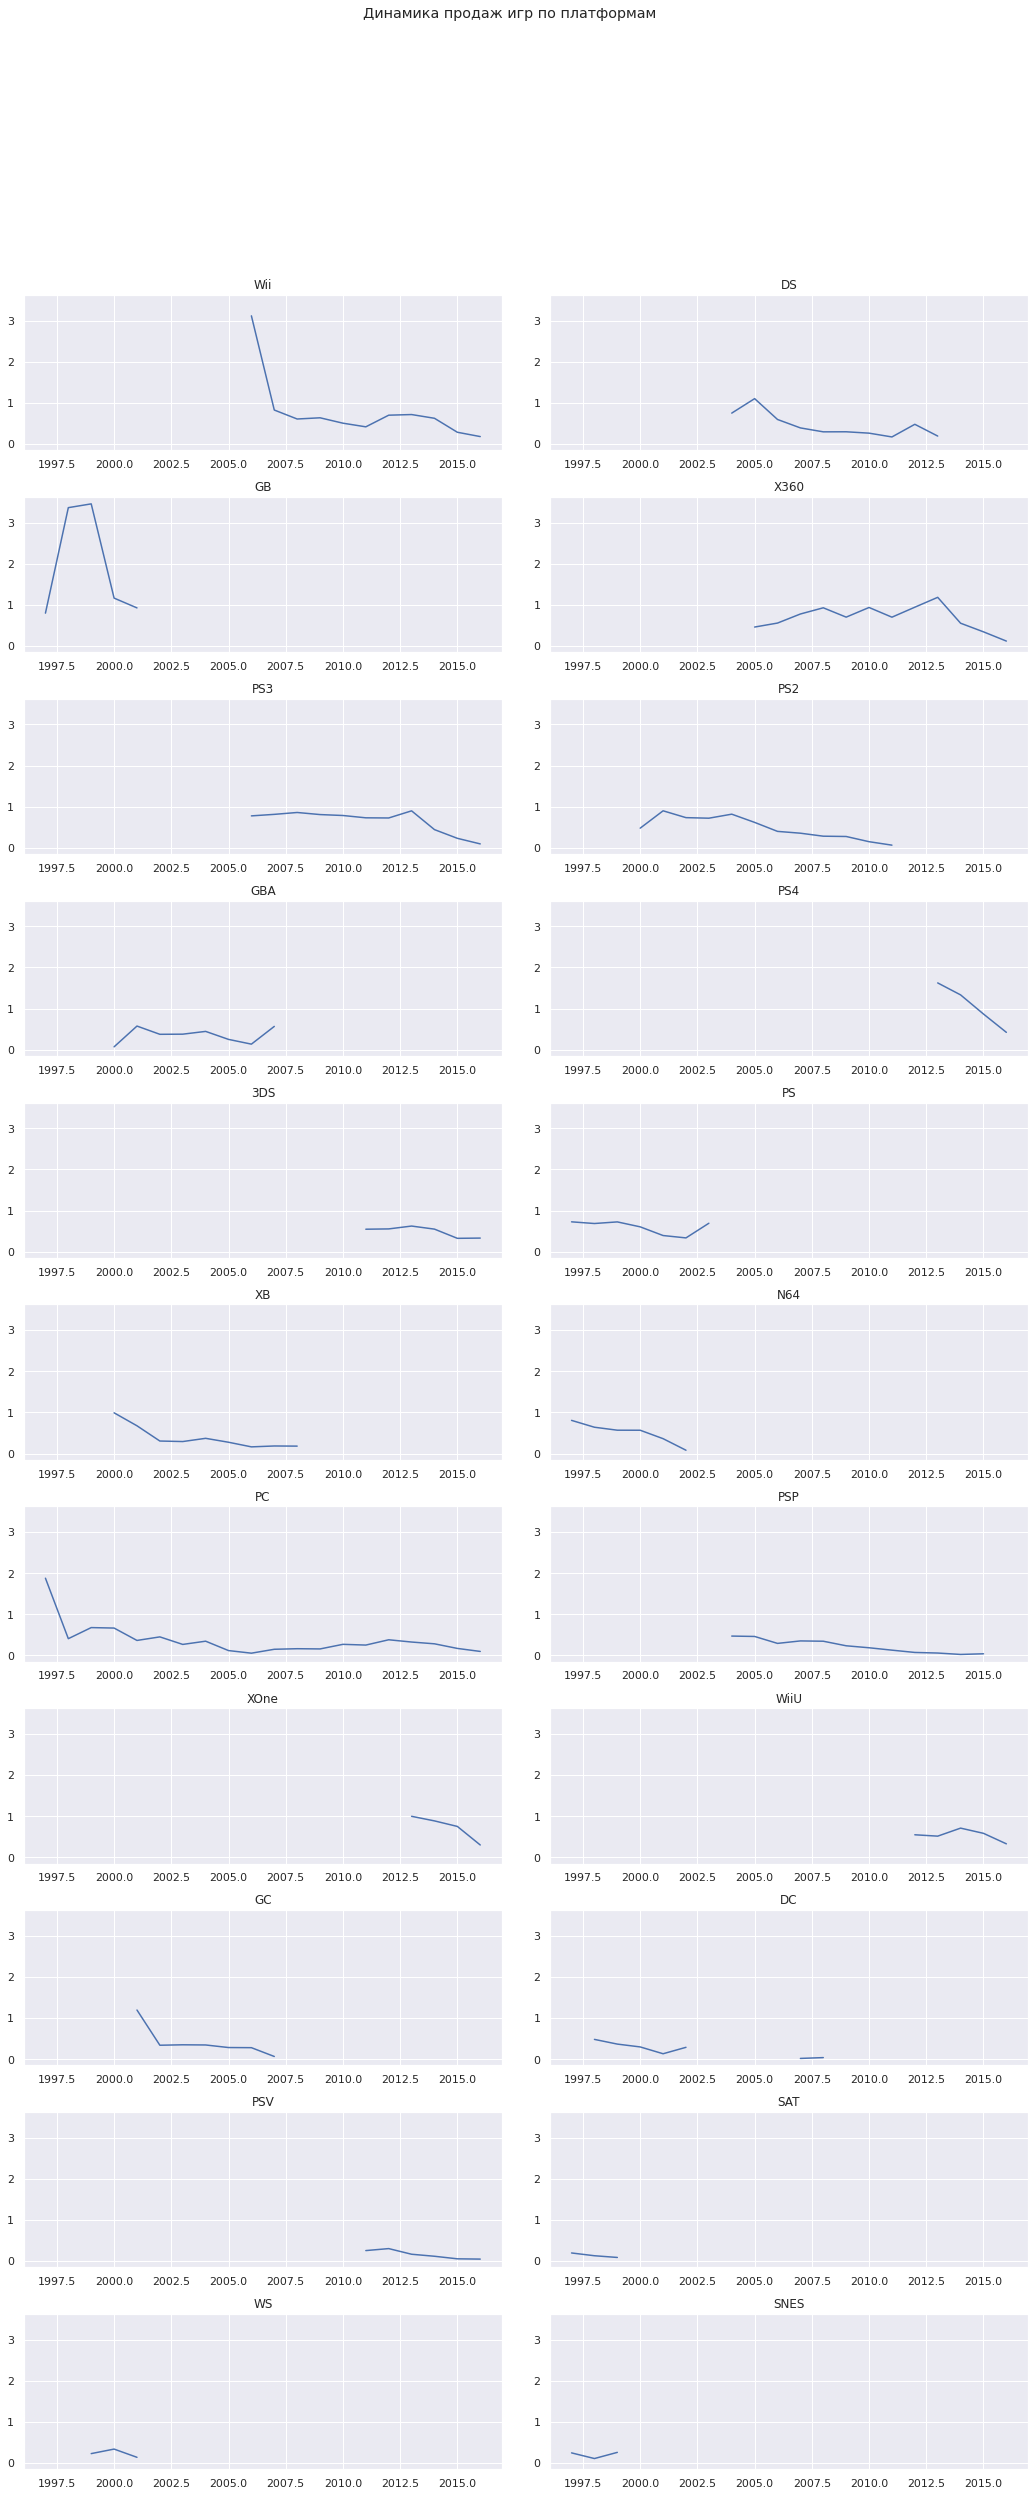

In [ ]:
platform_sales = pd.pivot_table(data, index = 'year_of_release', columns = 'platform', values = 'total_sales')

plt.figure(figsize = (18, 40))
sub_number= 1
platform_name = data['platform'].unique()
while sub_number <=data['platform'].nunique():
    if sub_number== 1:
        plt.subplot(11,2, sub_number)
    else:
        plt.subplot(11,2, sub_number, sharex=plt.subplot(11,2,1), sharey=plt.subplot(11,2,1))
    current_data = platform_sales[platform_name[sub_number-1]]
    plt.plot(current_data.index, current_data)
    plt.title(platform_name[sub_number-1])
    sub_number+=1

plt.suptitle('Динамика продаж игр по платформам')
plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.show()

Судя по графикам точкой отсчета для актуального периода следует взять окончание продаж игр на PS2

In [ ]:
data[(data['platform']=='PS2') & (~data['total_sales'].isna())]['year_of_release'].max()

2011

In [ ]:
data_before_2012 = data[data['year_of_release'] <2012 ] #сохраним для потомков
data = data[data['year_of_release'] >= 2012 ]

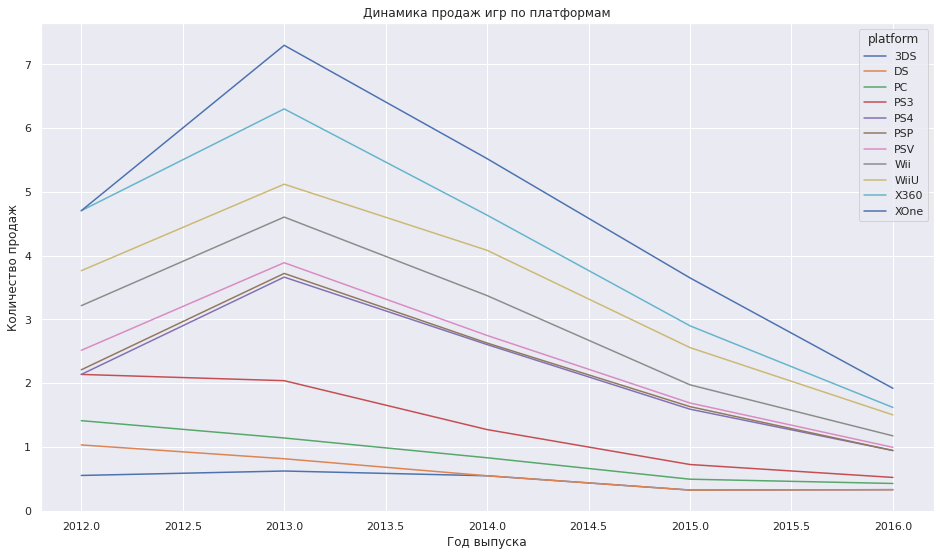

In [ ]:
platform_sales = pd.pivot_table(data, index = 'year_of_release', columns = 'platform', values = 'total_sales')
platform_sales.plot(stacked = True, figsize = (16,9), xlabel='Год выпуска', ylabel='Количество продаж')
plt.title('Динамика продаж игр по платформам')
plt.show()

На графике видны несколько лидирующих платформ, продажи которых хоть и соответствуют общему тренду на снижение, но все равно остаются успешнее остальных. Рассмотрим внимательно данные о первых 7 платформах, т.к. они имеют общий тренд, остальные судя по всему и без общего тренда шли на снижение по каким-то иным причинам.

In [ ]:
new_columns=['year_of_release']
col_names = platform_sales.columns.tolist()
for i in col_names:
    new_columns.append(i)
new_columns
platform_sales.reset_index()
platform_sales.columns = col_names
platform_sales.reset_index()

,year_of_release,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
0,2012,0.552258,0.478696,0.380656,0.725405,NaN,0.072547,0.305472,0.700323,0.548750,0.940943,NaN
1,2013,0.621648,0.192500,0.325789,0.898810,1.624375,0.058148,0.168095,0.715833,0.515476,1.181067,0.997895
2,2014,0.547000,NaN,0.282553,0.442222,1.333333,0.024000,0.119000,0.625000,0.710645,0.551429,0.886393
3,2015,0.323023,NaN,0.170400,0.230411,0.867883,0.040000,0.056818,0.285000,0.583929,0.341714,0.751750
4,2016,0.329130,NaN,0.097222,0.094737,0.422256,NaN,0.050000,0.180000,0.328571,0.116923,0.300575


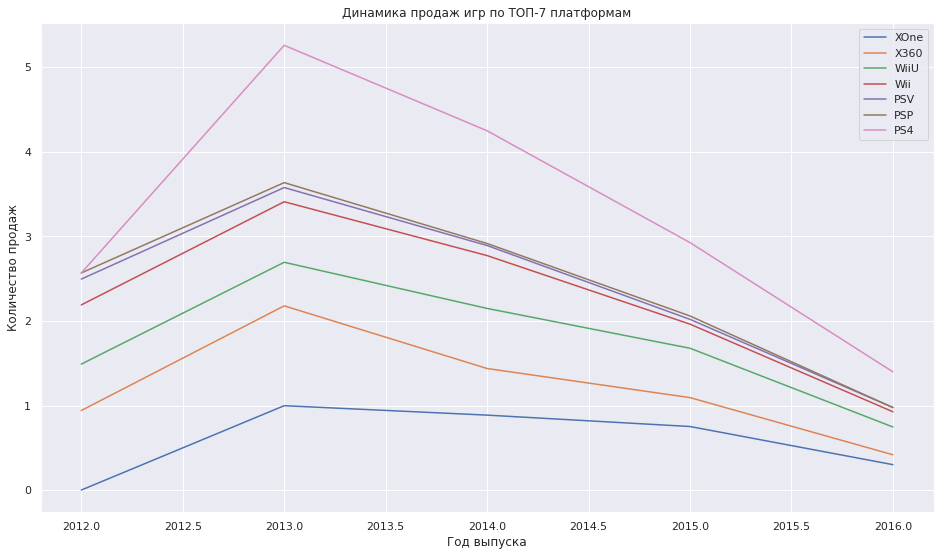

In [ ]:
top_7_platform= ['XOne','X360', 'WiiU', 'Wii','PSV', 'PSP','PS4']
platform_sales[['XOne','X360', 'WiiU', 'Wii','PSV', 'PSP','PS4']].plot(stacked = True, figsize = (16,9), xlabel='Год выпуска', ylabel='Количество продаж')
plt.title('Динамика продаж игр по ТОП-7 платформам')
plt.show()

In [ ]:
top_7_platform_data = data[data['platform'].isin(top_7_platform)]
top_7_platform_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
35,Call of Duty: Black Ops II,X360,2012,Shooter,8.25,4.24,0.07,1.12,83.0,4.8,M,13.68
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
60,Call of Duty: Ghosts,X360,2013,Shooter,6.73,2.56,0.04,0.91,73.0,2.6,M,10.24


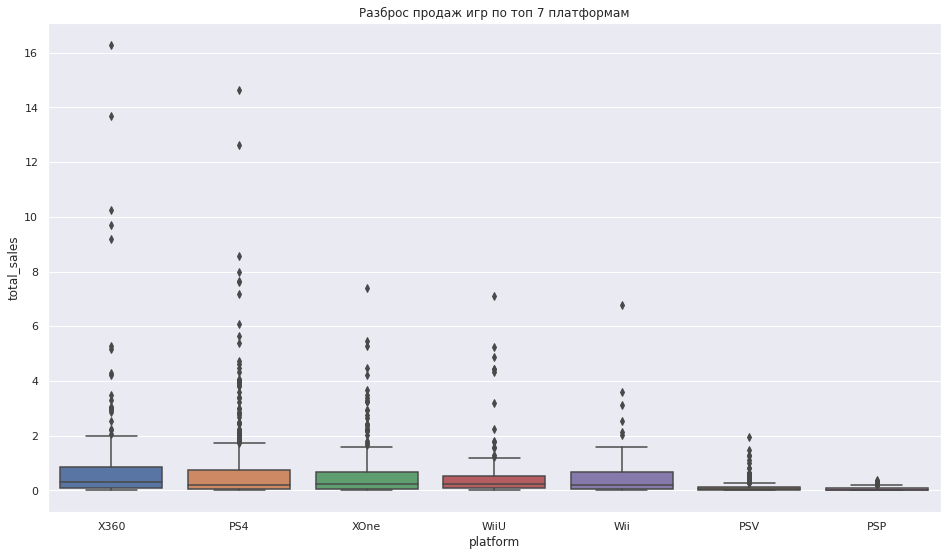

In [ ]:
sns.boxplot(x="platform", y="total_sales", data=top_7_platform_data)
sns.set(rc={'figure.figsize':(16,9)})
plt.title('Разброс продаж игр по топ 7 платформам')

plt.show()

Пока можно сделать вывод, что среди игр на X360 и  PS4 есть игры с аномально высоким количеством продаж. Попробуем проанализировать данные без этих аномалий

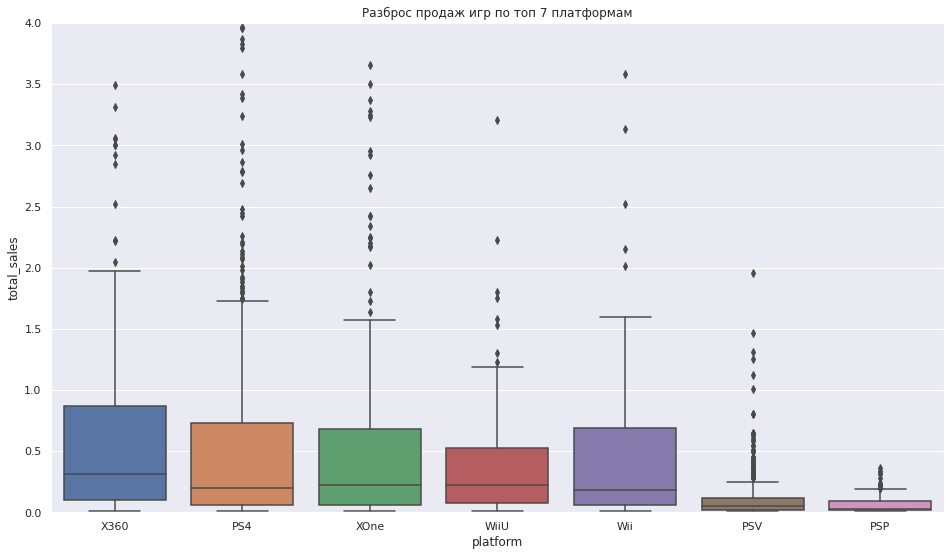

In [ ]:
sns.boxplot(x="platform", y="total_sales", data=top_7_platform_data)
plt.title('Разброс продаж игр по топ 7 платформам')

plt.ylim (0, 4)
plt.show()

Среди ТОП-5 платформ ('XOne','X360', 'WiiU', 'Wii','PS4') медианные значения по продажам игр соизмеримы, однако величина размаха сильно отличается.

6-е и 7-е место сильно отстают как по медиане так и по размаху.

Рассмотрим влияние оценки критиков и пользователей на продажи внутри одной платформы. В качестве испытуемого выберем самую успешную X360

In [ ]:
data_X360 = data[data['platform']== 'X360']

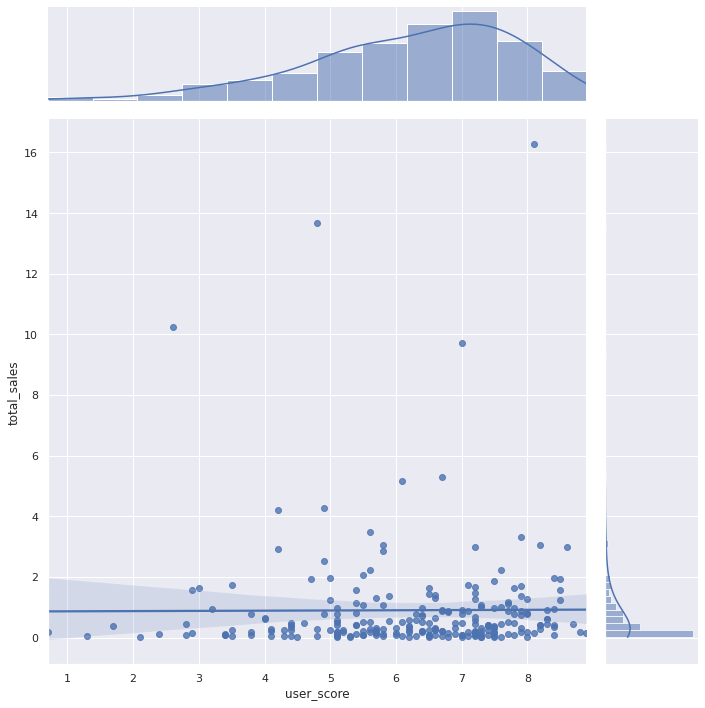

In [ ]:
sns.jointplot(data = data_X360,
              x = 'user_score',
              y = 'total_sales',
              kind = 'reg',
              height = 10)

plt.show()

Нет оснований предполагать, что количество продаж связано с оценкой пользователей

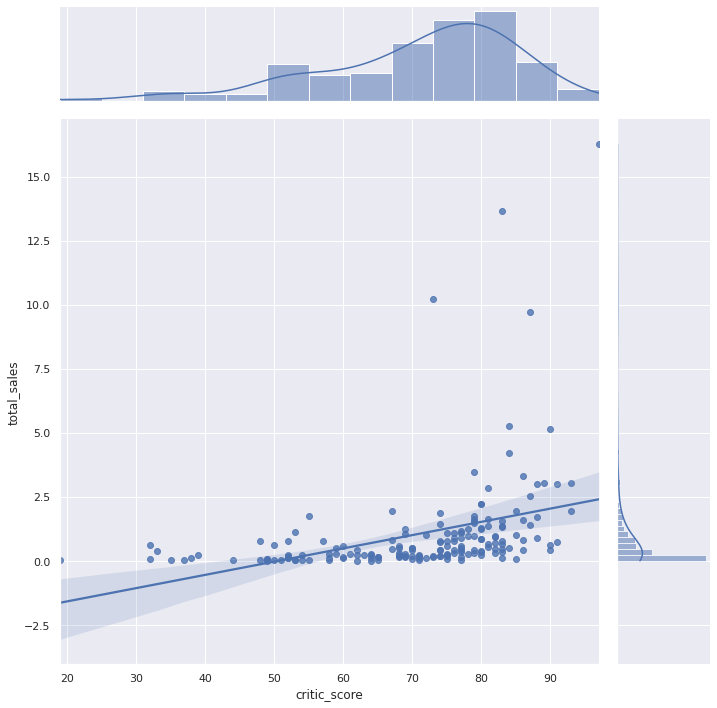

In [ ]:
sns.jointplot(data = data_X360,
              x = 'critic_score',
              y = 'total_sales',
              kind = 'reg',
              height = 10)

plt.show()

Можно предположить, что связь между оценкой критиков и количеством продаж есть, но врядли она сильная

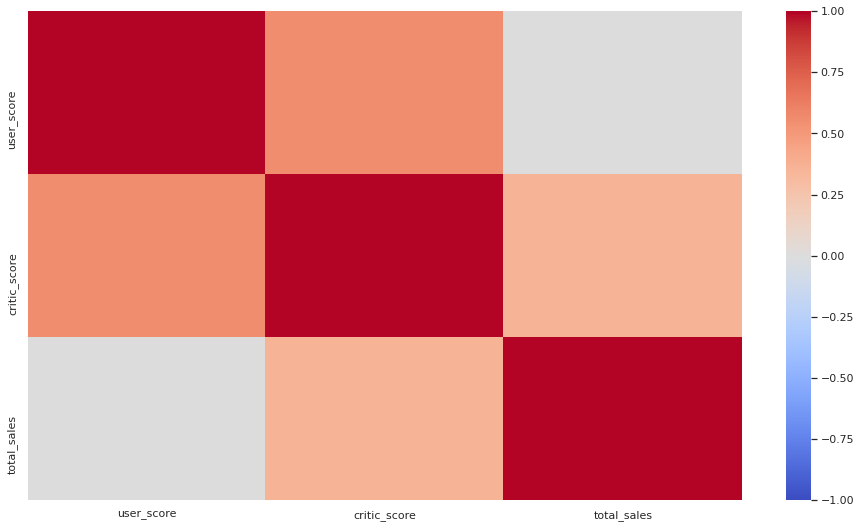

In [ ]:

sns.heatmap(data_X360[['user_score', 'critic_score', 'total_sales']].corr(),
            # дополнительно пропишем цветовую гамму
            cmap= 'coolwarm',
            # и зададим диапазон от -1 до 1
            vmin = -1, vmax = 1);

Видна корреляция между оценками критиков и оценками пользователей, однако количество проданных копий от них не зависят.

Проверим большем диапазоне данных

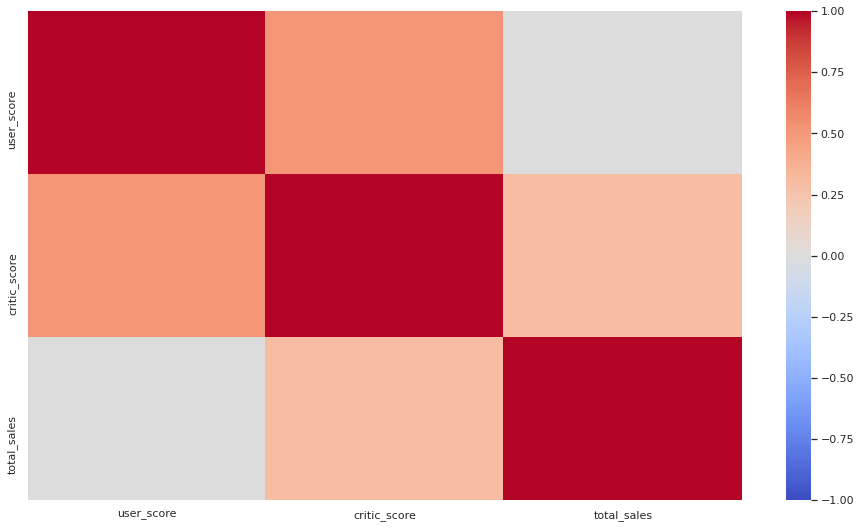

In [ ]:
sns.heatmap(data[['user_score', 'critic_score', 'total_sales']].corr(),
            # дополнительно пропишем цветовую гамму
            cmap= 'coolwarm',
            # и зададим диапазон от -1 до 1
            vmin = -1, vmax = 1);

Нет оснований полагать, что количество продаж игры значительно зависит от оценки пользователей или критиков.

Рассмотрим есть ли разница между играми разных жанров

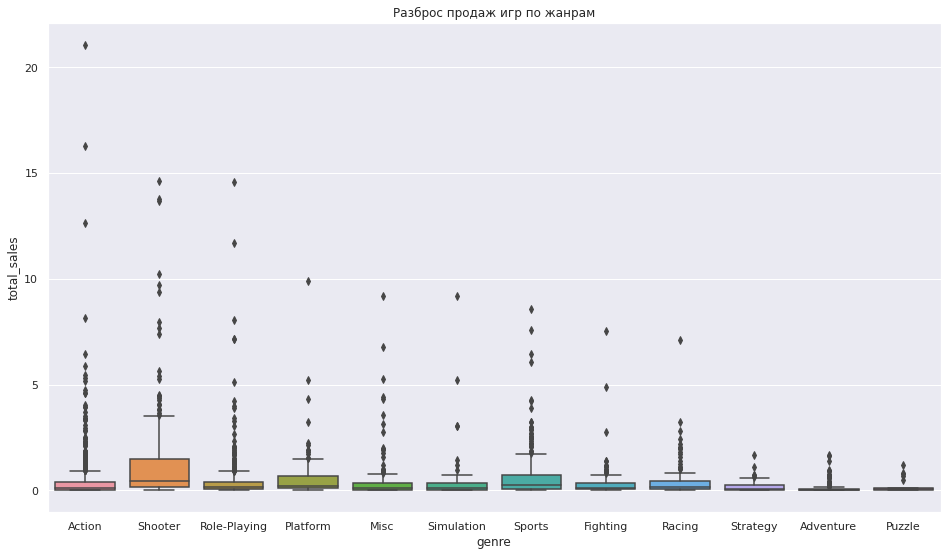

In [ ]:
sns.boxplot(x="genre", y="total_sales", data=data)
sns.set(rc={'figure.figsize':(16,9)})
plt.title('Разброс продаж игр по жанрам')
plt.show()

Явно выделяется жанр шутер, его размах даже в таком масштабе шире чем у остальных игр. Однако, наряду с шутерами в жанре Экшн и Ролеплэй достаточно аномально высоких продаж единичных игр.

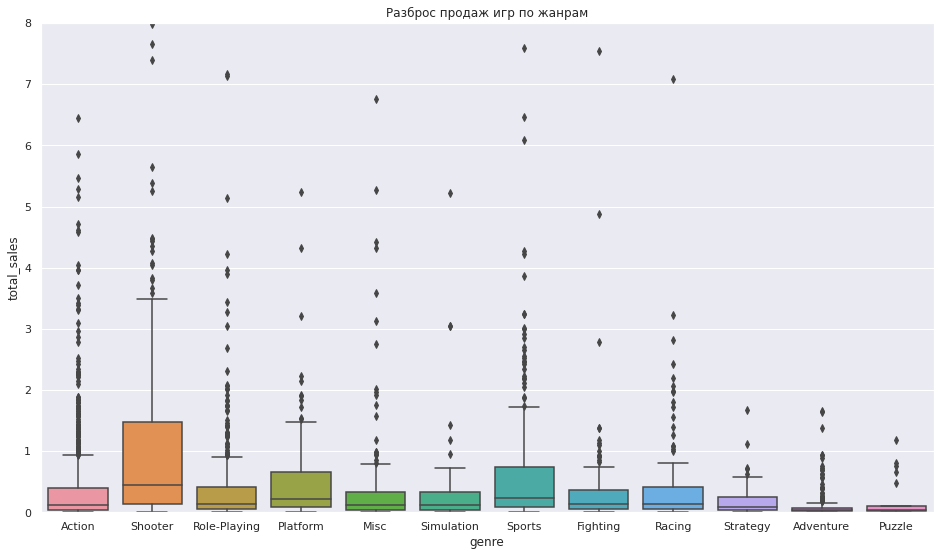

In [ ]:
sns.boxplot(x="genre", y="total_sales", data=data)
sns.set(rc={'figure.figsize':(16,9)})
plt.title('Разброс продаж игр по жанрам')
plt.ylim(0,8)
plt.show()

Наболее высокие медианные значения и размах продаж имеет жанр Шутер, далее спортивные игры и платформеры.

Экшн игры, ролевые игры, симуляторы, файтинги, гонки и особенные игры не попавшие ни в один жанр имеют соизмеримые медианы и размах.

Завершают цепочку стратегии, логические игры и приключения, их медианные значения и размах продаж оставляют желать лучшего

**Вывод:** по результатам проведенного анализа:
- целесообразными для построения прогноза на 2017 год были признаны данные по продажах игр с 2012 года и более поздние
- была выявлена общая тенденция по продажам игр, после пика в 2013 году количество продаваемых игр идет на спад.
- наиболее успешными по количеству продаж с учетом общего тренда являются платформы 'XOne','X360', 'WiiU', 'Wii','PS4'. Именно эти платформы являются наиболее предпочтительными для дальнейшего продвижения.
- не было выявлено значимой взаимосвязи между оценками зрителей и количеством продаж игры.
- так же не было выявлено значимой взаимосвязи между оценками критиков и количеством продаж игры.
- наиболее продаваемыми жанрами игр за исследуемый период являлись Шутеры, спортивные игры и платформеры

## Портрет пользователя

Рассмотрим продажи 5ти наиболее популярных платформ в разных регионах

In [ ]:
top_5_list = ['XOne','X360', 'WiiU', 'Wii','PS4']
top_5_data = data[data['platform'].isin(top_5_list)]
top_5_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
35,Call of Duty: Black Ops II,X360,2012,Shooter,8.25,4.24,0.07,1.12,83.0,4.8,M,13.68
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
60,Call of Duty: Ghosts,X360,2013,Shooter,6.73,2.56,0.04,0.91,73.0,2.6,M,10.24


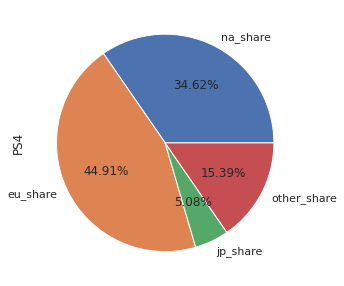

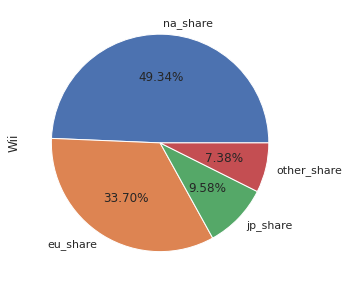

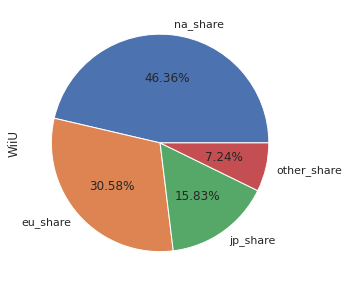

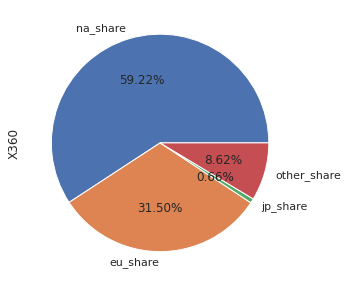

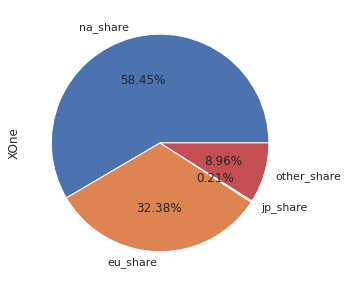

In [ ]:
top_5_data_pivot =top_5_data[['platform','na_sales', 'eu_sales', 'jp_sales','other_sales', 'total_sales']].groupby('platform').sum()
top_5_data_pivot['na_share'] = round(top_5_data_pivot['na_sales']/top_5_data_pivot['total_sales']*100, 2)
top_5_data_pivot['eu_share'] = round(top_5_data_pivot['eu_sales']/top_5_data_pivot['total_sales']*100, 2)
top_5_data_pivot['jp_share'] = round(top_5_data_pivot['jp_sales']/top_5_data_pivot['total_sales']*100, 2)
top_5_data_pivot['other_share'] = round(top_5_data_pivot['other_sales']/top_5_data_pivot['total_sales']*100, 2)

for index, row  in top_5_data_pivot.iterrows():
    row[['na_share','eu_share','jp_share', 'other_share']].plot(kind='pie', subplots=True,figsize=(5,5), autopct='%1.2f%%')
    plt.xticks = ['NA', 'EU', 'JP', 'Other']
    plt.show()



Наибольшую долю в продажах почти на всех платформах составляет Сверно-американский сегмент, за исключением PS4 - здесь лидирует Европейский сегмент и здесь же наибольшая доля продаж в "других странах". Наибольшая из всех доля японского рынка на платформе 'WiiU'.

,na_sales,na_share
platform,,
X360,140.05,23.70
PS4,108.74,18.40
PS3,103.38,17.49
XOne,93.12,15.76
3DS,55.31,9.36


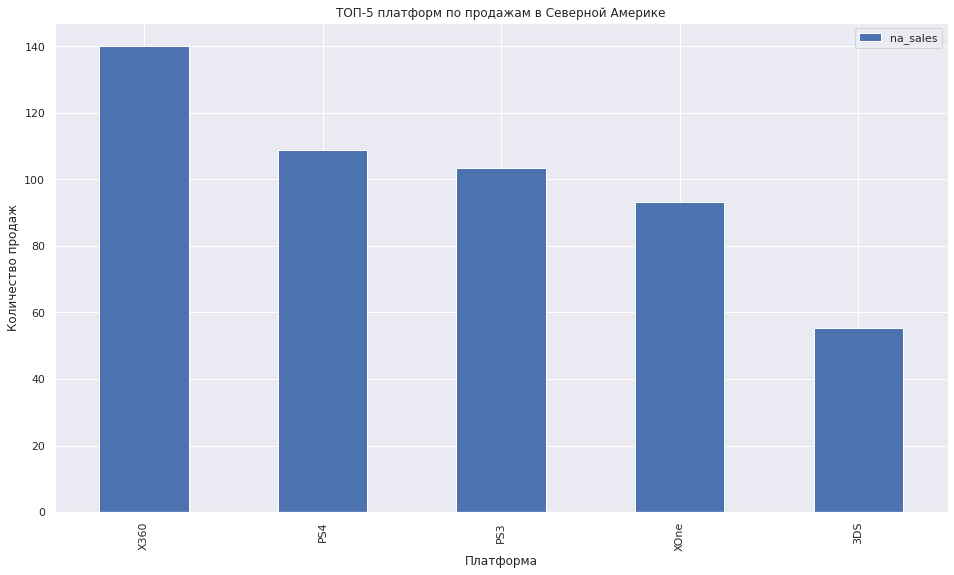

In [ ]:
grouped_platform = data[['platform','na_sales', 'eu_sales', 'jp_sales', 'total_sales']].groupby('platform').sum()
total_na = grouped_platform['na_sales'].sum()
total_eu = grouped_platform['eu_sales'].sum()
total_jp = grouped_platform['jp_sales'].sum()
grouped_platform['na_share'] = round(grouped_platform['na_sales']/total_na*100, 2)
grouped_platform['eu_share'] = round(grouped_platform['eu_sales']/total_eu*100, 2)
grouped_platform['jp_share'] = round(grouped_platform['jp_sales']/total_jp*100, 2)


display(grouped_platform[['na_sales', 'na_share']].sort_values (by = ['na_sales'], ascending = False ).head())

grouped_platform[['na_sales']].sort_values (by = ['na_sales'], ascending = False ).head().plot(kind='bar',title = 'ТОП-5 платформ по продажам в Северной Америке', xlabel='Платформа', ylabel ='Количество продаж' )
plt.show()

Наибольшие доли от продаж в северно-американском сегменте составляют продажи X360,  PS2 и Wii (более 10% продаж по каждой платформе), однако нельзя сказать что эти платформы кардинально успешнее остальных, т.к. конкуренция, в том числе и с платформами ниже чем топ-3 сохраняется

,eu_sales,eu_share
platform,,
PS4,141.09,27.84
PS3,106.86,21.08
X360,74.52,14.70
XOne,51.59,10.18
3DS,42.64,8.41


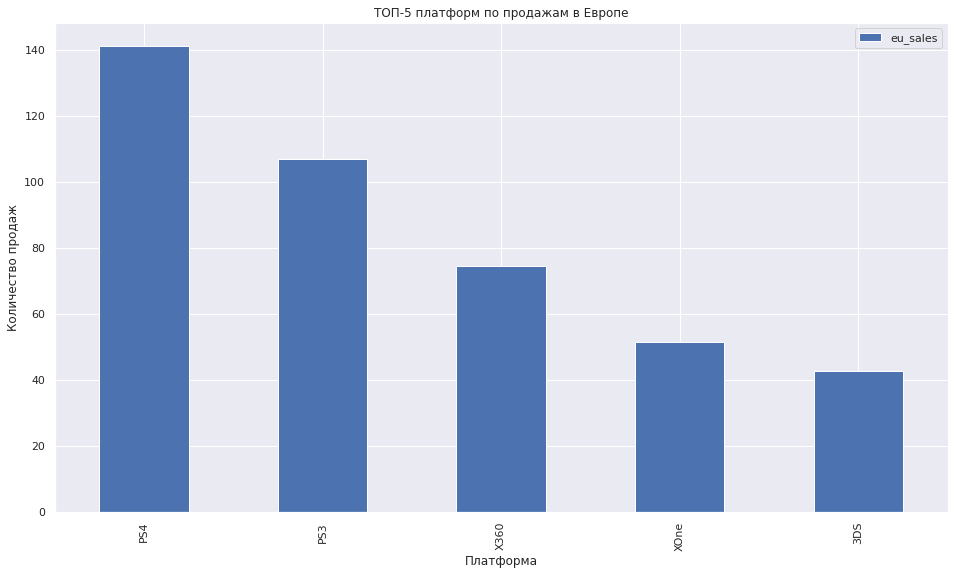

In [ ]:
display(grouped_platform[['eu_sales', 'eu_share']].sort_values (by = ['eu_sales'], ascending = False ).head())
grouped_platform[['eu_sales']].sort_values (by = ['eu_sales'], ascending = False ).head().plot(kind='bar',title = 'ТОП-5 платформ по продажам в Европе', xlabel='Платформа', ylabel ='Количество продаж' )
plt.show()

В Европе лидируют платформы PS2, PS3 и X360, но так же более 10% продаж составляют продажи на Wii

,jp_sales,jp_share
platform,,
3DS,87.79,45.59
PS3,35.29,18.32
PSV,21.04,10.93
PS4,15.96,8.29
WiiU,13.01,6.76


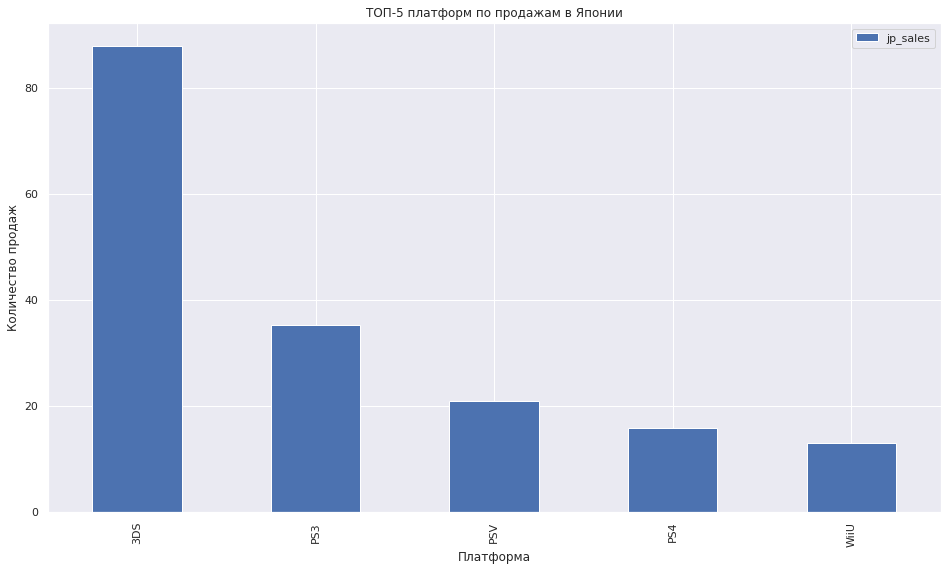

In [ ]:
display(grouped_platform[['jp_sales', 'jp_share']].sort_values (by = ['jp_sales'], ascending = False ).head())

grouped_platform[['jp_sales']].sort_values (by = ['jp_sales'], ascending = False ).head().plot(kind='bar',title = 'ТОП-5 платформ по продажам в Японии', xlabel='Платформа', ylabel ='Количество продаж' )
plt.show()

На японском рынке лидирует платформа DS и только следом за ней с неплохим отрывом идут PS и PS2. Здесь же в топ 5 попадает SNES с 9% от продаж, хотя в других регионах эта платформа не популярна

In [ ]:
top_5_list = ['Shooter','Sports', 'Platform', 'Racing','Misc']
top_5_data = data[data['genre'].isin(top_5_list)]
top_5_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79
35,Call of Duty: Black Ops II,X360,2012,Shooter,8.25,4.24,0.07,1.12,83.0,4.8,M,13.68
60,Call of Duty: Ghosts,X360,2013,Shooter,6.73,2.56,0.04,0.91,73.0,2.6,M,10.24
62,New Super Mario Bros. 2,3DS,2012,Platform,3.66,3.14,2.47,0.63,78.0,7.2,E,9.90


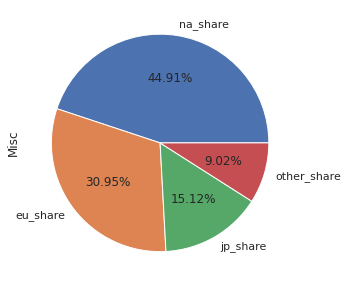

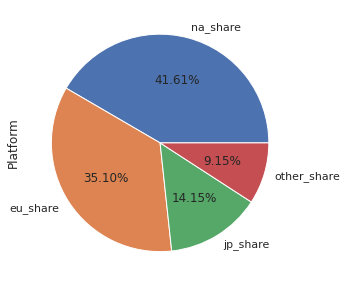

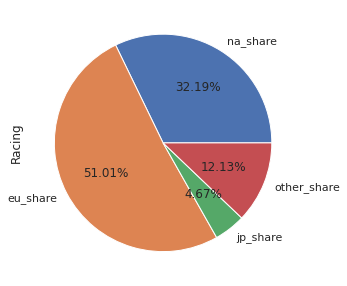

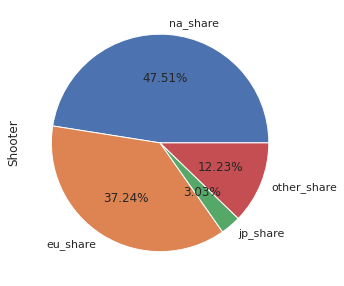

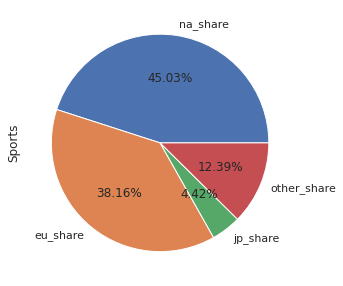

In [ ]:
top_5_data_pivot =top_5_data[['genre','na_sales', 'eu_sales', 'jp_sales','other_sales', 'total_sales']].groupby('genre').sum()
top_5_data_pivot['na_share'] = round(top_5_data_pivot['na_sales']/top_5_data_pivot['total_sales']*100, 2)
top_5_data_pivot['eu_share'] = round(top_5_data_pivot['eu_sales']/top_5_data_pivot['total_sales']*100, 2)
top_5_data_pivot['jp_share'] = round(top_5_data_pivot['jp_sales']/top_5_data_pivot['total_sales']*100, 2)
top_5_data_pivot['other_share'] = round(top_5_data_pivot['other_sales']/top_5_data_pivot['total_sales']*100, 2)

for index, row  in top_5_data_pivot.iterrows():
    row[['na_share','eu_share','jp_share', 'other_share']].plot(kind='pie', subplots=True,figsize=(5,5), autopct='%1.2f%%')
    plt.xticks = ['NA', 'EU', 'JP', 'Other']
    plt.show()


Северно-американский рынок составляет массивную долю продаж во всех 5ти жанрах, однако наибольший перекос составляют игры в жанрах шутер и платформер

,na_sales,na_share
genre,,
Action,177.84,30.09
Shooter,144.77,24.50
Sports,81.53,13.80
Role-Playing,64.00,10.83
Misc,38.19,6.46


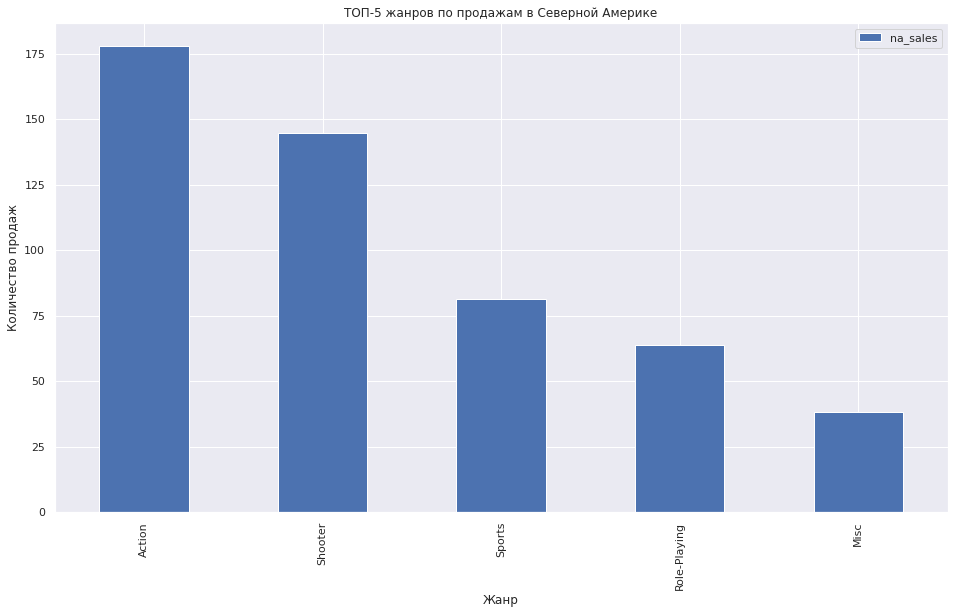

In [ ]:
grouped_genre = data[['genre','na_sales', 'eu_sales', 'jp_sales', 'total_sales']].groupby('genre').sum()
total_na = grouped_genre['na_sales'].sum()
total_eu = grouped_genre['eu_sales'].sum()
total_jp = grouped_genre['jp_sales'].sum()
grouped_genre['na_share'] = round(grouped_genre['na_sales']/total_na*100, 2)
grouped_genre['eu_share'] = round(grouped_genre['eu_sales']/total_eu*100, 2)
grouped_genre['jp_share'] = round(grouped_genre['jp_sales']/total_jp*100, 2)


display(grouped_genre[['na_sales', 'na_share']].sort_values (by = ['na_sales'], ascending = False ).head())

grouped_genre[['na_sales']].sort_values (by = ['na_sales'], ascending = False ).head().plot(kind='bar',title = 'ТОП-5 жанров по продажам в Северной Америке', xlabel='Жанр', ylabel ='Количество продаж' )
plt.show()

В Северной Америке наиболее популярны экшены, спортивные игры и шутеры

,eu_sales,eu_share
genre,,
Action,159.34,31.44
Shooter,113.47,22.39
Sports,69.09,13.63
Role-Playing,48.53,9.58
Racing,27.29,5.38


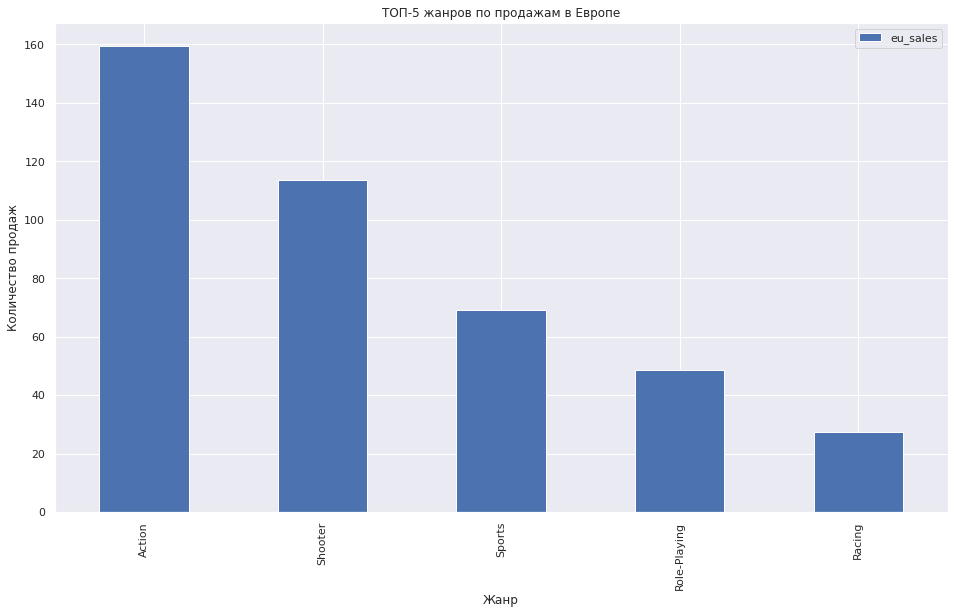

In [ ]:
display(grouped_genre[['eu_sales', 'eu_share']].sort_values (by = ['eu_sales'], ascending = False ).head())

grouped_genre[['eu_sales']].sort_values (by = ['eu_sales'], ascending = False ).head().plot(kind='bar',title = 'ТОП-5 жанров по продажам в Европе', xlabel='Жанр', ylabel ='Количество продаж' )
plt.show()

В Европе популярна та же тройка, однако в том пять вместо платформеров попали гонки

,jp_sales,jp_share
genre,,
Role-Playing,65.44,33.98
Action,52.80,27.42
Misc,12.86,6.68
Simulation,10.41,5.41
Fighting,9.44,4.90


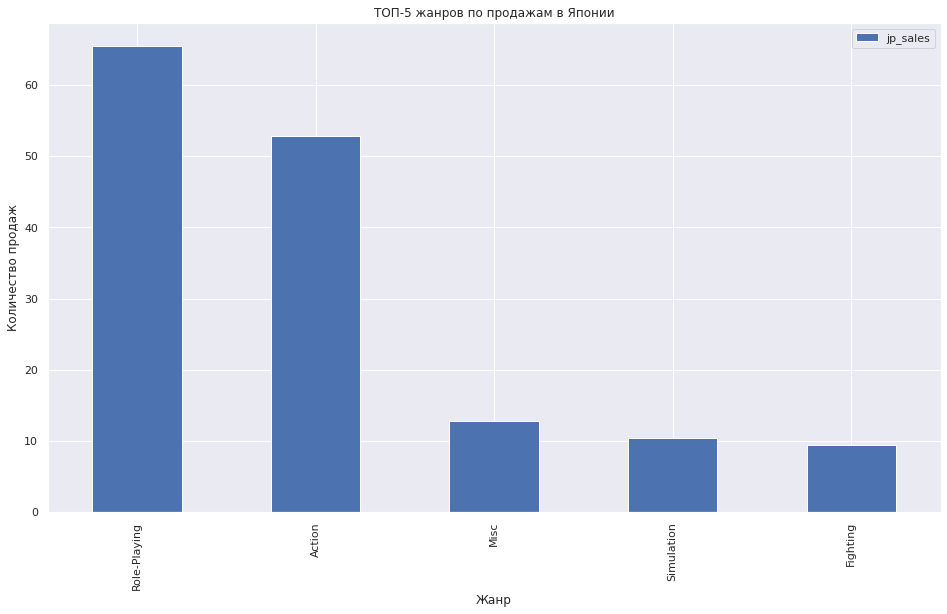

In [ ]:
display(grouped_genre[['jp_sales', 'jp_share']].sort_values (by = ['jp_sales'], ascending = False ).head())

grouped_genre[['jp_sales']].sort_values (by = ['jp_sales'], ascending = False ).head().plot(kind='bar',title = 'ТОП-5 жанров по продажам в Японии', xlabel='Жанр', ylabel ='Количество продаж' )
plt.show()

В японии лидируют ролевые игры с большим отрывом, и только после них плетутся экшены, спрот и платформеры. Во всех трех топах есть игры "без определенного жанра". Возможно это не самый успешный вариант, но его так же можно рассмотреть в кандидаты, т.к. он популярен во всех регионах

Проверим влияет ли рейтинг ESRB на продажи в отдельном регионе?

Для этого возьмем данные только с заполненным рейтингом и исключим из данных рейтинги
- «RP» («Rating Pending») — «Рейтинг ожидается» - эти данные скорее помешают анализу, чем ему помогут
- Рейтинг К-А (Kids to Adults) устарел, ранее использовался вместо рейтинга «E» («Everyone») — «Для всех». В целях анализа, эти рейтинги стоит уравнять

In [ ]:
data_ERSB = data[~data['rating'].isna()]
display(data_ERSB[data_ERSB['rating']=='K-A']['rating'].count())
data_ERSB = data_ERSB.replace({'rating':{'K-A':'E'}})
display(data_ERSB[data_ERSB['rating']=='K-A']['rating'].count())

0

0

In [ ]:
display(data_ERSB[data_ERSB['rating']== 'RP']['rating'].count())
data_ERSB = data_ERSB[data_ERSB['rating']!= 'RP']
display(data_ERSB[data_ERSB['rating']== 'RP']['rating'].count())

0

0

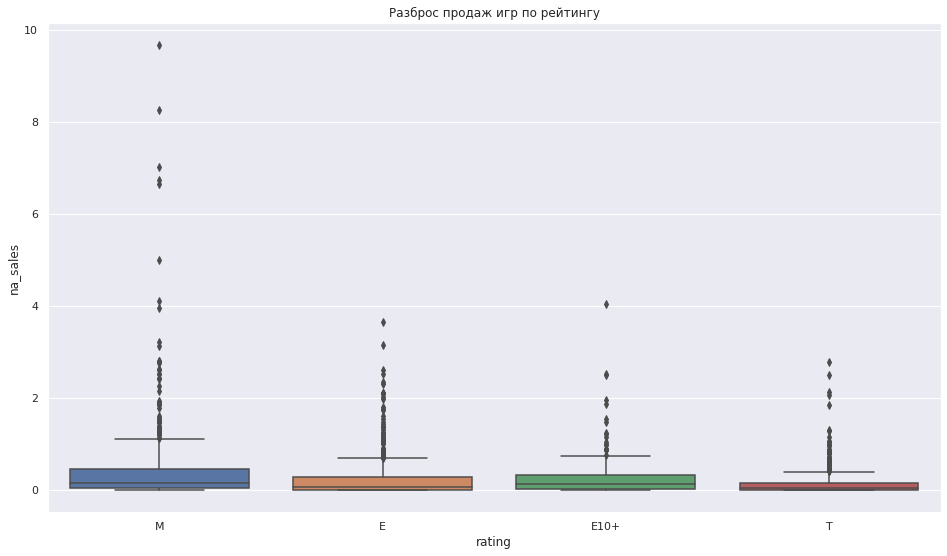

In [ ]:
sns.boxplot(x="rating", y="na_sales", data=data_ERSB)
sns.set(rc={'figure.figsize':(16,9)})
plt.title('Разброс продаж игр по рейтингу')
plt.show()

Уже в таком масштабе явно видно что в Северной америке любят игры с насилием и кровью, среди них больше всех других аномально продаваемых проектов.

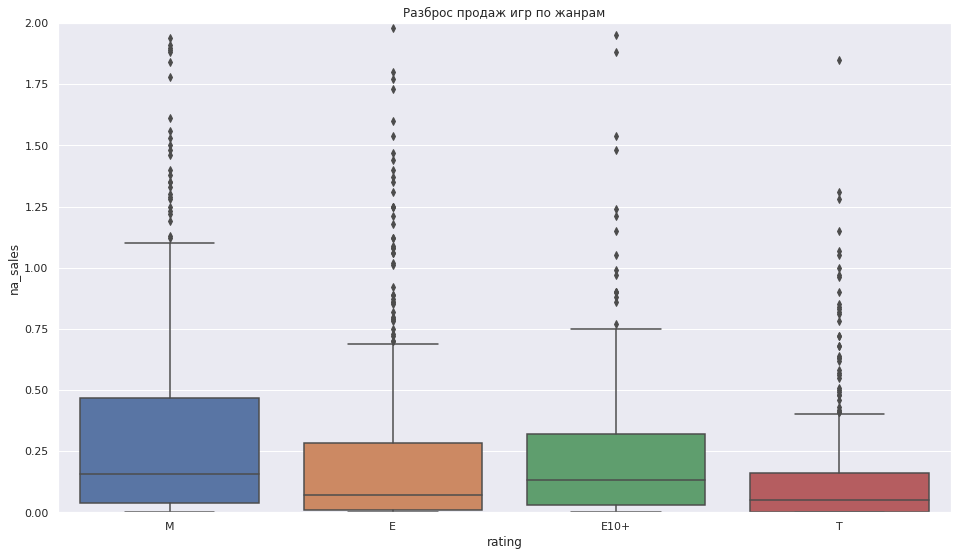

In [ ]:
sns.boxplot(x="rating", y="na_sales", data=data_ERSB)
sns.set(rc={'figure.figsize':(16,9)})
plt.title('Разброс продаж игр по жанрам')
plt.ylim(0,2)
plt.show()

В северной америке лидируют игры с рейтингом "М" -Для взрослых и с рейтингом Е10+ - старше 10 лет - их медианные значения сопоставими, однако размах больше все же у рейтинга М.. На третьем месте игры для всех (от 6 лет - рейтинг "Е") и на последнем месте игры для подростков (от 13 лет - рейтинг "Т"), медианное значение рейтинга Е так же немногим больше рейтинга Т, однако размах рейтинга Е шире чем у Т.

**Выводы:**

Для развития в Северной америке следует выбрать экшены, спортивные игры и шутеры на платформах X360,  PS2 и Wii. Так же стоит обратить внимание на игры с рейтингом М - содержащие материалы для взрослых

Для развития в Европе следует выбрать те же экшены, спортивные игры и шутеры но на PS2, PS3 и X360

Для развития в Японии нужно вкладываться в ролевые игры на платформах DS - здесь явный перекос в сторону этого жанра и платформы

## Проверка гипотез

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

H0 - Средний пользовательский рейтинг платформы Xbox One равен среднему пользовательскому рейтингу PC

H1 - Средний пользовательский рейтинг платформы Xbox One НЕ равен среднему пользовательскому рейтингу PC

In [ ]:
rating_XboxOne = data[(data['platform']=='XOne') & (~data['user_score'].isna())]['user_score']
rating_PC = data[(data['platform']=='PC') & (~data['user_score'].isna())]['user_score']

alpha = 0.05
results = st.ttest_ind(rating_XboxOne, rating_PC,  alternative='two-sided')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 0.5535080500643661
Нет оснований отвергнуть нулевую гипотезу


**Результат:** Есть основания предполагать, что средний пользовательский рейтинг платформы Xbox One равен среднему пользовательскому рейтингу PC


Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

H0 - Средний пользовательский рейтинг жанра Action равен среднему пользовательскому рейтингу жанра Sports

H1 - Средний пользовательский рейтинг жанра Action НЕ равен среднему пользовательскому рейтингу жанра Sports

In [ ]:
rating_Action  = data[(data['genre']=='Action') & (~data['user_score'].isna())]['user_score']
rating_Sports  = data[(data['genre']=='Sports') & (~data['user_score'].isna())]['user_score']

alpha = 0.05
results = st.ttest_ind(rating_Action, rating_Sports,  alternative='two-sided')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 3.7163089460934874e-26
Отвергаем нулевую гипотезу


**Результат:** Есть основания предполагать, что средние пользовательские рейтинги жанров Action и Sports различаются.

При формировании гипотез мы использовали основное правило, что нулевая гипотеза должна быть на равенство средних значений совокупностей, а альтернативная гипотеза должна дополнять условия нулевой требуемыми вариантами (не равно, больше, меньше).
Поскольку выборки две выборки независимы, использовался тест для независимых выборок

# Вывод

Проведен анализ данных о продажах игр, выпущенных за период с 1980 по 2016 год в разрезе жанров, платформ и регионах продаж, снабженных оценками рейтинга ESRB, оценками пользователей и критиков.

В рамках предварительной обработки данных были выявлены и удалены 2% данных с пропусками в разделах в колонке с годом выпуска игры и с наименованием игры, поскольку достоверного способа восстановить эти данные найти не удалось. Были проведены расчет суммарных продаж, а так же привдение данных к подходящим для исследования типам.

По результатам иследовательского анализа:
- целесообразными для построения прогноза на 2017 год были признаны данные по продажах игр с 2012 года и более поздние
- была выявлена общая тенденция по продажам игр, после пика в 2013 году количество продаваемых игр идет на спад.
- наиболее успешными по количеству продаж с учетом общего тренда являются платформы 'XOne','X360', 'WiiU', 'Wii','PS4'. Именно эти платформы являются наиболее предпочтительными для дальнейшего продвижения.
- не было выявлено значимой взаимосвязи между оценками зрителей и количеством продаж игры.
- так же не было выявлено значимой взаимосвязи между оценками критиков и количеством продаж игры.
- наиболее продаваемыми в целом жанрами игр за исследуемый период являлись Шутеры, спортивные игры и платформеры

В качестве потенциально популярных продуктов по регионам были определены следующие:
- Для развития в Северной америке следует выбрать экшены, спортивные игры и шутеры на платформах X360,  PS2 и Wii. Так же стоит обратить внимание на игры с рейтингом М - содержащие материалы для взрослых

- Для развития в Европе следует выбрать те же экшены, спортивные игры и шутеры но на PS2, PS3 и X360

- Для развития в Японии нужно вкладываться в ролевые игры на платформах DS - здесь явный перекос в сторону этого жанра и платформы

В качестве резервного продукта для обеспечения "надежной подушки безопасности" можно выбрать игры Misc("без определенного жанра"). Этот жанр в занимает почетное пятое место в топе однако, он почти одинаково популярен во всех трех основных регионах продаж.

По результатам проверки гипотез было выявлено следующее:
- Есть основания предполагать, что средний пользовательский рейтинг платформы Xbox One равен среднему пользовательскому рейтингу PC
- Есть основания предполагать, что средние пользовательские рейтинги жанров Action и Sports различаются.